In [5]:
!which python 

/opt/anaconda3/envs/spiketurnpike_postanalysis/bin/python


In [6]:
!pip show pyabf

Name: pyabf
Version: 2.3.8
Summary: Python library for reading files in Axon Binary Format (ABF)
Home-page: http://swharden.com/pyabf
Author: Scott W Harden
Author-email: SWHarden@gmail.com
License: MIT License
Location: /opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages
Requires: matplotlib, numpy, pytest
Required-by: 


In [7]:
from spiketurnpike_postanalysis.Extract_patch_data_from_abf import PatchDataExtractor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import re  # Import the re module for regular expressions
from matplotlib.backends.backend_pdf import PdfPages
import pyabf
import pyabf.plot
from scipy.signal import find_peaks
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multitest import multipletests
    
from scipy.stats import ttest_ind
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
from scipy.stats import ks_2samp

/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages/pyabf/plot.py:14: UserWarning: abf.plot is obsolete and should not be used
  warnings.warn("abf.plot is obsolete and should not be used")


In [46]:
class BladePatchDataProcessor:
    def __init__(self, base_path, time_units="sec", voltage_units="mV"):
        """
        Initialize the BladePatchDataProcessor with the base path.

        Args:
            base_path (str): Path to the BLADe_patch_data folder.
        """
        self.base_path = base_path  # Base directory path
        self.dataframe = None  # DataFrame to store metadata
        self.unique_groups = None  # List of unique group names
        self.time_units = time_units
        self.voltage_units = voltage_units
        self._abf_cache = {}  # Cache for ABF objects to avoid repeated loading, Cache for ABF objects: {(group, recording_id, label): abf_obj}

    def process_data(self):
        """
        Process the BLADe_patch_data folder to extract metadata about .abf files.

        This method populates the `dataframe` and `unique_groups` attributes.
        """
        data = []

        # Walk through each group in the base path
        for group_dir in os.listdir(self.base_path):
            group_path = os.path.join(self.base_path, group_dir)
            if not os.path.isdir(group_path):
                continue  # Skip non-directory files

            # Determine linking pattern based on the group
            if group_dir == "L + CS-Veh":
                identifier_pattern = r"Veh-\d+"
            else:
                identifier_pattern = r"CTZ-\d+"

            # Look for .abf files in the group directory
            for file_name in os.listdir(group_path):
                if file_name.endswith(".abf"):
                    # Parse the label ("Before" or "After")
                    if "Before" in file_name:
                        label = "Before"
                    elif "After" in file_name:
                        label = "After"
                    else:
                        continue  # Skip files without "Before" or "After"

                    # Extract linking identifier (e.g., "CTZ-1", "Veh-2")
                    match = re.search(identifier_pattern, file_name)
                    if not match:
                        print(f"Warning: No linking identifier found in file {file_name}. Skipping.")
                        continue
                    recording_id = match.group(0)

                    # Append metadata to the list
                    data.append({
                        "Group": group_dir,
                        "Recording_ID": recording_id,
                        "Label": label,
                        "File_Path": os.path.join(group_path, file_name)
                    })

        # Convert the list of metadata to a DataFrame
        self.dataframe = pd.DataFrame(data)

        # Sort the DataFrame by Group and Recording ID for clarity
        if not self.dataframe.empty:
            self.dataframe = self.dataframe.sort_values(by=["Group", "Recording_ID", "Label"]).reset_index(drop=True)
            # Extract unique group names
            self.unique_groups = self.dataframe["Group"].unique().tolist()
        else:
            self.unique_groups = []

    def get_recording_ids(self, group):
        """
        Given a group name, return all unique recording IDs associated with that group.
        """
        group_data = self.dataframe[self.dataframe["Group"] == group]
        return group_data["Recording_ID"].unique()

    def get_abf_file(self, group, recording_id, label):
        """
        Return a pyabf.ABF object for the given group, recording_id, and label.
        Uses caching to avoid reloading the file multiple times.
        """
        key = (group, recording_id, label)
        if key in self._abf_cache:
            return self._abf_cache[key]

        entry = self.dataframe[(self.dataframe["Group"] == group) &
                               (self.dataframe["Recording_ID"] == recording_id) & 
                               (self.dataframe["Label"] == label)]
        if entry.empty:
            raise ValueError(f"No entry found for Group: {group}, Recording ID: {recording_id} with label: {label}")

        file_path = entry["File_Path"].iloc[0]
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"ABF file not found at: {file_path}")

        abf = pyabf.ABF(file_path)
        self._abf_cache[key] = abf
        return abf

    def get_sweep_data(self, group, recording_id, label, sweep_number, channel=0):
        """
        Retrieve time and voltage arrays for a given sweep from the specified group and recording.
        """
        abf = self.get_abf_file(group, recording_id, label)
        abf.setSweep(sweepNumber=sweep_number, channel=channel)
        return abf.sweepX, abf.sweepY

    def colors_binned(self, count, colormap="viridis", reverse=False):
        cmap = plt.get_cmap(colormap)
        colors = [cmap(i / count) for i in range(count)]
        if reverse:
            colors.reverse()
        return colors

    def plot_sweeps(self, ax, group, recording_id, label, sweep_numbers=None,
                    offsetXsec=0.3, offsetYunits=40, startAtSec=0, endAtSec=None,
                    color=None, alpha=0.5, linewidth=1, hideAxis=True):
        """
        Plot multiple sweeps from a given group, recording, and label on the given axis.
        This version includes parameters for offsetting and time-limiting sweeps,
        and the option to hide axes.
        """
        abf = self.get_abf_file(group, recording_id, label)
        if sweep_numbers is None:
            sweep_numbers = abf.sweepList

        data_rate = abf.dataRate
        i1 = int(data_rate * startAtSec)
        i2 = int(data_rate * endAtSec) if endAtSec else None

        # Handle colors
        if color is None and len(sweep_numbers) > 1:
            colors = self.colors_binned(len(sweep_numbers))
        else:
            colors = [color] * len(sweep_numbers)

        for i, sweep_num in enumerate(sweep_numbers):
            time, voltage = self.get_sweep_data(group, recording_id, label, sweep_num)
            ax.plot(
                time[i1:i2] + offsetXsec * sweep_num,
                voltage[i1:i2] + offsetYunits * sweep_num,
                color=colors[i] if colors[i] else 'C0',
                alpha=alpha,
                linewidth=linewidth
            )

        # Remove all axis lines, ticks, and labels if requested
        if hideAxis:
            ax.axis('off')
        else:
            # If you ever want axes, you can customize here:
            ax.set_xlabel(self.time_units)
            ax.set_ylabel(self.voltage_units)

    def plot_scalebar(self, ax, scaleXms=200, scaleYmV=50, fontSize=8, lineWidth=2,
                    hideTicks=True, hideFrame=True):
        """
        Add a scale bar to the given axis dynamically.
        By default, shows a scale bar for 200 ms (0.2 s) and 50 mV.

        Args:
            ax (matplotlib.axes.Axes): The axis to draw the scale bar on.
            scaleXms (float): The horizontal scale length in milliseconds (default 200 ms).
            scaleYmV (float): The vertical scale length in millivolts (default 50 mV).
            fontSize (int): Font size of the scale bar labels.
            lineWidth (int): Line width of the scale bar lines.
            hideTicks (bool): If True, hides the axis ticks.
            hideFrame (bool): If True, hides the axis frame/spines.

        The scale bar will be placed in the lower-right corner of the axis.
        """
        # Convert ms to seconds for data coordinates
        scaleXsize_data = scaleXms / 1000.0  # e.g., 200 ms = 0.2 s
        scaleYsize_data = scaleYmV  # mV stays mV

        x1, x2 = ax.get_xlim()
        y1, y2 = ax.get_ylim()
        xs, ys = abs(x2 - x1), abs(y2 - y1)

        # Position the scale bar in the lower-right corner
        scaleBarPadX = 0.10
        scaleBarPadY = 0.10
        scaleBarX = x2 - scaleBarPadX * xs
        scaleBarX2 = scaleBarX - scaleXsize_data
        scaleBarY = y1 + scaleBarPadY * ys
        scaleBarY2 = scaleBarY + scaleYsize_data

        scaleBarXs = [scaleBarX2, scaleBarX, scaleBarX]
        scaleBarYs = [scaleBarY, scaleBarY, scaleBarY2]

        # Hide ticks/frames if requested
        if hideTicks:
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        if hideFrame:
            for spine in ax.spines.values():
                spine.set_visible(False)

        # Draw the scale bar
        ax.plot(scaleBarXs, scaleBarYs, 'k-', lw=lineWidth)

        # Padding for labels
        lblPadMult = 0.005 + 0.002 * lineWidth
        lblPadX = xs * lblPadMult
        lblPadY = ys * lblPadMult

        # Create labels with units
        # For time, we label in ms; for voltage, in mV
        time_label = f"{scaleXms} ms"
        voltage_label = f"{scaleYmV} mV"

        # Add text labels
        ax.text((scaleBarX + scaleBarX2) / 2, scaleBarY - lblPadY, time_label,
                ha='center', va='top', fontsize=fontSize)
        ax.text(scaleBarX + lblPadX, (scaleBarY + scaleBarY2) / 2, voltage_label,
                ha='left', va='center', fontsize=fontSize)

    def plot_before_after_comparison(self, group, recording_id,
                                    before_label="Before", after_label="After",
                                    sweep_numbers=None, startAtSec=0, endAtSec=1.5,
                                    offsetXsec=0.3, offsetYunits=40,
                                    color_before=None, color_after="red",
                                    alpha=0.5, linewidth=1,
                                    add_suptitle=True, suptitle_fontsize=14):
        """
        Create a figure comparing Before and After sweeps for a single recording in a group.
        This version allows control over offsets, time, and whether to show titles or axes.
        """
        fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

        # Plot Before sweeps
        self.plot_sweeps(axes[0], group, recording_id, before_label,
                        sweep_numbers=sweep_numbers,
                        offsetXsec=offsetXsec, offsetYunits=offsetYunits,
                        startAtSec=startAtSec, endAtSec=endAtSec,
                        color=color_before, alpha=alpha, linewidth=linewidth, hideAxis=True)

        # Plot After sweeps
        self.plot_sweeps(axes[1], group, recording_id, after_label,
                        sweep_numbers=sweep_numbers,
                        offsetXsec=offsetXsec, offsetYunits=offsetYunits,
                        startAtSec=startAtSec, endAtSec=endAtSec,
                        color=color_after, alpha=alpha, linewidth=linewidth, hideAxis=True)

        # Optionally add a figure-level title
        if add_suptitle:
            fig.suptitle(f"Group: {group}, Recording: {recording_id}",
                        fontsize=suptitle_fontsize)

        plt.tight_layout()
        return fig, axes

    def export_group_to_pdf(self, group, output_pdf_path,
                            before_label="Before", after_label="After",
                            sweep_numbers=None, startAtSec=0, endAtSec=1.5,
                            offsetXsec=0.3, offsetYunits=40,
                            color_before=None, color_after="red",
                            alpha=0.5, linewidth=1):
        """
        Create a multipage PDF for all recordings in a given group.
        Each page shows Before/After comparison for a single recording in that group.
        """
        os.makedirs(os.path.dirname(output_pdf_path), exist_ok=True)
        recording_ids = self.get_recording_ids(group)

        with PdfPages(output_pdf_path) as pdf:
            for recording_id in recording_ids:
                before_entry = self.dataframe[(self.dataframe["Group"] == group) &
                                            (self.dataframe["Recording_ID"] == recording_id) &
                                            (self.dataframe["Label"] == before_label)]
                after_entry = self.dataframe[(self.dataframe["Group"] == group) &
                                            (self.dataframe["Recording_ID"] == recording_id) &
                                            (self.dataframe["Label"] == after_label)]

                # Only create the page if both Before and After exist for this (Group, Recording_ID)
                if before_entry.empty or after_entry.empty:
                    continue

                fig, axes = self.plot_before_after_comparison(
                    group, recording_id,
                    before_label=before_label, after_label=after_label,
                    sweep_numbers=sweep_numbers,
                    startAtSec=startAtSec, endAtSec=endAtSec,
                    offsetXsec=offsetXsec, offsetYunits=offsetYunits,
                    color_before=color_before, color_after=color_after,
                    alpha=alpha, linewidth=linewidth,
                    add_suptitle=True
                )

                # Add a scale bar to the bottom axis if desired
                # Adjust hideFrame and hideTicks to maintain a clean look
                self.plot_scalebar(axes[1], hideTicks=True, hideFrame=True)

                pdf.savefig(fig)
                plt.close(fig)
            
    def export_all_groups_to_pdfs(self, output_dir,
                                before_label="Before", after_label="After",
                                sweep_numbers=None,
                                startAtSec=0, endAtSec=1.5,
                                offsetXsec=0.3, offsetYunits=40,
                                color_before=None, color_after="red",
                                alpha=0.5, linewidth=1):
        """
        Export one PDF per group, with each PDF containing all recordings 
        (Before/After) for that group.

        Args:
            output_dir (str): Directory to save all the PDF files.
            before_label (str): Label for the "Before" condition.
            after_label (str): Label for the "After" condition.
            sweep_numbers (list or None): Specific sweeps to plot. 
                                        If None, all sweeps are plotted.
            startAtSec (float): Start time (seconds) of the data to plot.
            endAtSec (float): End time (seconds) of the data to plot.
            offsetXsec (float): Horizontal offset per sweep.
            offsetYunits (float): Vertical offset per sweep.
            color_before (str or None): Color for "Before" sweeps. 
                                        None means use default or colormap.
            color_after (str): Color for "After" sweeps.
            alpha (float): Transparency of the sweep lines.
            linewidth (float): Width of the sweep lines.
        """
        os.makedirs(output_dir, exist_ok=True)
        for grp in self.unique_groups:
            pdf_path = os.path.join(output_dir, f"{grp}_plots.pdf")
            self.export_group_to_pdf(
                group=grp,
                output_pdf_path=pdf_path,
                before_label=before_label,
                after_label=after_label,
                sweep_numbers=sweep_numbers,
                startAtSec=startAtSec,
                endAtSec=endAtSec,
                offsetXsec=offsetXsec,
                offsetYunits=offsetYunits,
                color_before=color_before,
                color_after=color_after,
                alpha=alpha,
                linewidth=linewidth
            )
            print(f"PDF saved for group {grp} at: {pdf_path}")

    def get_summary(self):
        """
        Get a summary of the processed data.

        Returns:
            str: A summary string including number of groups and recordings.
        """
        if self.dataframe is None:
            return "No data processed yet."

        summary = (
            f"Total Groups: {len(self.unique_groups)}\n"
            f"Unique Groups: {self.unique_groups}\n"
            f"Total Recordings: {len(self.dataframe)}"
        )
        return summary
    
    def plot_sweeps_pdf(self, output_dir):
        """
        Generate a multipage PDF for each group, with each page containing Before and After sweeps.

        Args:
            output_dir (str): Path to save the generated PDF files.
        """
        if self.dataframe is None or self.dataframe.empty:
            print("No data to plot. Run `process_data` first.")
            return

        os.makedirs(output_dir, exist_ok=True)

        # Group by unique groups
        for group in self.unique_groups:
            group_data = self.dataframe[self.dataframe["Group"] == group]
            pdf_path = os.path.join(output_dir, f"{group}.pdf")
            saved_pages = 0  # Track the number of pages added to the PDF

            # Determine linking pattern based on the group
            if group == "L + CS-Veh":
                identifier_pattern = "Veh"
            else:
                identifier_pattern = "CTZ"

            # Extract unique linking pairs
            linking_ids = group_data["Recording_ID"].str.extract(f"({identifier_pattern}-\d+)")[0].dropna().unique()

            with PdfPages(pdf_path) as pdf:
                for link_id in linking_ids:
                    # Filter "Before" and "After" files for the current linking pair
                    before_file = group_data[(group_data["Recording_ID"].str.contains(link_id)) & (group_data["Label"] == "Before")]["File_Path"]
                    after_file = group_data[(group_data["Recording_ID"].str.contains(link_id)) & (group_data["Label"] == "After")]["File_Path"]

                    if before_file.empty or after_file.empty:
                        print(f"Skipping incomplete pair for Link ID: {link_id} in group {group}")
                        continue  # Skip if "Before" or "After" is missing

                    before_file = before_file.iloc[0]
                    after_file = after_file.iloc[0]

                    # Create the figure with 1x2 layout
                    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
                    fig.suptitle(f"Group: {group}, Link ID: {link_id}", fontsize=14)

                    # Plot Before
                    abf_before = pyabf.ABF(before_file)
                    for sweepNumber in abf_before.sweepList:
                        abf_before.setSweep(sweepNumber)
                        offset = 140 * sweepNumber
                        axes[0].plot(abf_before.sweepX, abf_before.sweepY + offset, color='C0')
                    axes[0].set_title("Before")
                    axes[0].get_yaxis().set_visible(False)
                    axes[0].set_xlabel(abf_before.sweepLabelX)

                    # Plot After
                    abf_after = pyabf.ABF(after_file)
                    for sweepNumber in abf_after.sweepList:
                        abf_after.setSweep(sweepNumber)
                        offset = 140 * sweepNumber
                        axes[1].plot(abf_after.sweepX, abf_after.sweepY + offset, color='C1')
                    axes[1].set_title("After")
                    axes[1].get_yaxis().set_visible(False)
                    axes[1].set_xlabel(abf_after.sweepLabelX)

                    # Save the current figure to the PDF
                    pdf.savefig(fig)
                    plt.close(fig)
                    saved_pages += 1

                if saved_pages == 0:
                    print(f"No valid data to plot for group '{group}'. Deleting empty PDF.")
                    os.remove(pdf_path)
                else:
                    print(f"Saved PDF for group '{group}' to: {pdf_path}")              

    def detect_action_potentials(self, group, recording_id, label, sweep_number, height=None, prominence=None, distance=None, width=None):
            """
            Detect and plot action potentials (APs) for a specific recording from the DataFrame.

            Args:
                group (str): The group name.
                recording_id (str): The recording ID (e.g., "CTZ-1").
                label (str): The label ("Before" or "After").
                sweep_number (int): Sweep number to analyze.
                height (float, optional): Minimum height of peaks (APs) to detect.
                prominence (float, optional): Minimum prominence of peaks (APs) to detect.
                distance (float, optional): Minimum distance between consecutive peaks.
                width (float, optional): Minimum width of peaks.

            Returns:
                dict: A dictionary with sweep number, detected AP count, and peak indices.
            """
            # Locate the file path from the DataFrame
            entry = self.dataframe[
                (self.dataframe["Group"] == group) &
                (self.dataframe["Recording_ID"] == recording_id) &
                (self.dataframe["Label"] == label)
            ]

            if entry.empty:
                raise ValueError(f"No entry found for Group: {group}, Recording ID: {recording_id}, Label: {label}")

            file_path = entry["File_Path"].iloc[0]

            # Load the ABF file
            abf = pyabf.ABF(file_path)
            abf.setSweep(sweepNumber=sweep_number)

            # Extract time (X-axis) and voltage (Y-axis) data
            time = abf.sweepX
            voltage = abf.sweepY

            # Detect peaks using scipy's find_peaks
            peaks, properties = find_peaks(
                voltage,
                height=height,
                prominence=prominence,
                distance=distance,
                width=width
            )

            # Count the number of action potentials (peaks)
            ap_count = len(peaks)

            # Plot the sweep with peaks overlaid
            plt.figure(figsize=(10, 6))
            plt.plot(time, voltage, label="Voltage Trace", color="C0")
            plt.plot(time[peaks], voltage[peaks], "x", label="Detected Peaks", color="C3")
            plt.title(f"Group: {group}, Recording ID: {recording_id}, Sweep {sweep_number}: Detected {ap_count} Action Potentials")
            plt.xlabel("Time (s)")
            plt.ylabel("Voltage (mV)")
            plt.legend()
            plt.show()

            # Return a summary of results
            return {
                "group": group,
                "recording_id": recording_id,
                "label": label,
                "sweep_number": sweep_number,
                "action_potential_count": ap_count,
                "peak_indices": peaks
            }
            
    def create_group_pdf_with_peaks(self, output_dir, height=None, prominence=None, distance=None, width=None):
        """
        Generate a 2x1 multipage PDF for each group. Each page contains "Before" and "After"
        sweeps of a single recording with action potential peaks annotated.

        Args:
            output_dir (str): Path to save the generated PDF files.
            height (float, optional): Minimum height of peaks (APs) to detect.
            prominence (float, optional): Minimum prominence of peaks (APs) to detect.
            distance (float, optional): Minimum distance between consecutive peaks.
            width (float, optional): Minimum width of peaks.
        """
        if self.dataframe is None or self.dataframe.empty:
            print("No data to plot. Run `process_data` first.")
            return

        os.makedirs(output_dir, exist_ok=True)

        for group in self.unique_groups:
            group_data = self.dataframe[self.dataframe["Group"] == group]
            pdf_path = os.path.join(output_dir, f"{group}_wide.pdf")

            with PdfPages(pdf_path) as pdf:
                # Get unique recording IDs for the group
                recording_ids = group_data["Recording_ID"].unique()

                for recording_id in recording_ids:
                    # Locate Before and After entries
                    before_entry = group_data[(group_data["Recording_ID"] == recording_id) & (group_data["Label"] == "Before")]
                    after_entry = group_data[(group_data["Recording_ID"] == recording_id) & (group_data["Label"] == "After")]

                    if before_entry.empty or after_entry.empty:
                        print(f"Skipping incomplete pair for Recording ID: {recording_id} in group {group}")
                        continue

                    # Load Before and After ABF files
                    before_file = before_entry["File_Path"].iloc[0]
                    after_file = after_entry["File_Path"].iloc[0]
                    before_abf = pyabf.ABF(before_file)
                    after_abf = pyabf.ABF(after_file)

                    # Create a 2x1 figure for the recording
                    fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
                    fig.suptitle(f"Group: {group}, Recording ID: {recording_id}", fontsize=16)

                    # Plot Before sweeps (Top Panel)
                    before_peak_counts = []
                    for sweep_number in before_abf.sweepList:
                        before_abf.setSweep(sweepNumber=sweep_number)
                        time = before_abf.sweepX
                        voltage = before_abf.sweepY

                        # Detect peaks
                        peaks, properties = find_peaks(
                            voltage,
                            height=height,
                            prominence=prominence,
                            distance=distance,
                            width=width
                        )

                        # Count peaks and store for annotation
                        before_peak_counts.append(len(peaks))

                        # Plot the sweep with peaks
                        offset = 140 * sweep_number  # Offset to stack sweeps visually
                        axes[0].plot(time, voltage + offset, label=f"Sweep {sweep_number}", color="C0")
                        axes[0].plot(time[peaks], voltage[peaks] + offset, "x", color="C3")

                        # Annotate number of peaks and sweep number for Before sweeps
                        for sweep_number, peak_count in enumerate(before_peak_counts):
                            axes[0].text(
                                -0.05,  # Slightly to the left of the x-axis start
                                140 * sweep_number,  # Same vertical position as the trace
                                f"Sweep {sweep_number}: {peak_count} APs",  # Add sweep number and AP count
                                fontsize=10,
                                color="C0",
                                ha="right"  # Align text to the right
                            )

                    axes[0].set_title("Before")
                    axes[0].get_yaxis().set_visible(False)

                    # Plot After sweeps (Bottom Panel)
                    after_peak_counts = []
                    for sweep_number in after_abf.sweepList:
                        after_abf.setSweep(sweepNumber=sweep_number)
                        time = after_abf.sweepX
                        voltage = after_abf.sweepY

                        # Detect peaks
                        peaks, properties = find_peaks(
                            voltage,
                            height=height,
                            prominence=prominence,
                            distance=distance,
                            width=width
                        )

                        # Count peaks and store for annotation
                        after_peak_counts.append(len(peaks))

                        # Plot the sweep with peaks
                        offset = 140 * sweep_number  # Offset to stack sweeps visually
                        axes[1].plot(time, voltage + offset, label=f"Sweep {sweep_number}", color="C1")
                        axes[1].plot(time[peaks], voltage[peaks] + offset, "x", color="C4")
                        
                        # Annotate number of peaks and sweep number for After sweeps
                        for sweep_number, peak_count in enumerate(after_peak_counts):
                            axes[1].text(
                                -0.05,  # Slightly to the left of the x-axis start
                                140 * sweep_number,  # Same vertical position as the trace
                                f"Sweep {sweep_number}: {peak_count} APs",  # Add sweep number and AP count
                                fontsize=10,
                                color="C1",
                                ha="right"  # Align text to the right
                            )
                    axes[1].set_title("After")
                    axes[1].get_yaxis().set_visible(False)

                    # Decorate the figure
                    axes[1].set_xlabel("Time (s)")
                    for ax in axes:
                        ax.set_ylabel("Voltage (mV)")
                        ax.legend(loc="upper right")

                    # Save the current page to the PDF
                    pdf.savefig(fig)
                    plt.close(fig)

            print(f"Saved wide PDF for group '{group}' to: {pdf_path}")
            
    def process_peaks(self, height=None, prominence=None, distance=None, width=None, save_csv_path=None):
        """
        Process all recordings to detect action potentials (peaks) for each sweep
        and optionally save the results to a CSV file.

        Args:
            height (float, optional): Minimum height of peaks (APs) to detect.
            prominence (float, optional): Minimum prominence of peaks (APs) to detect.
            distance (float, optional): Minimum distance between consecutive peaks.
            width (float, optional): Minimum width of peaks.
            save_csv_path (str, optional): Path to save the processed peaks data as a CSV file.

        Returns:
            None: Stores the results in self.peak_dataframe and optionally saves it as a CSV.
        """
        if self.dataframe is None or self.dataframe.empty:
            print("No data to process. Run `process_data` first.")
            return

        peak_data = []

        for group in self.unique_groups:
            group_data = self.dataframe[self.dataframe["Group"] == group]

            for _, row in group_data.iterrows():
                recording_id = row["Recording_ID"]
                label = row["Label"]
                file_path = row["File_Path"]

                # Load the ABF file
                abf = pyabf.ABF(file_path)

                for sweep_number in abf.sweepList:
                    abf.setSweep(sweepNumber=sweep_number)
                    voltage = abf.sweepY

                    # Detect peaks
                    peaks, _ = find_peaks(
                        voltage,
                        height=height,
                        prominence=prominence,
                        distance=distance,
                        width=width
                    )

                    # Append results to the list
                    peak_data.append({
                        "Group": group,
                        "Recording_ID": recording_id,
                        "Label": label,
                        "Sweep_Number": sweep_number,
                        "AP_Count": len(peaks)
                    })

        # Create a DataFrame from the results
        self.peak_dataframe = pd.DataFrame(peak_data)
        print(f"Processed peaks for {len(self.peak_dataframe)} sweeps.")

        # Save to CSV if path is provided
        if save_csv_path:
            self.peak_dataframe.to_csv(save_csv_path, index=False)
            print(f"Saved peak data to {save_csv_path}.")
                     
    def import_csv_and_plot_mean_peaks(self, csv_path, output_pdf_path):
        """
        Import a CSV file containing peak data and plot the mean AP counts
        for "Before" and "After" sweeps for each group.

        Args:
            csv_path (str): Path to the CSV file containing peak data.
            output_pdf_path (str): Path to save the output PDF.

        Returns:
            None
        """
        # Load the CSV into a DataFrame
        try:
            peak_data = pd.read_csv(csv_path)
        except FileNotFoundError:
            print(f"File not found: {csv_path}")
            return

        # Validate the required columns
        required_columns = ["Group", "Recording_ID", "Label", "Sweep_Number", "AP_Count"]
        if not all(col in peak_data.columns for col in required_columns):
            print("The CSV file is missing one or more required columns.")
            return

        # Ensure the output directory exists
        os.makedirs(os.path.dirname(output_pdf_path), exist_ok=True)

        # Open a PDF for plotting
        with PdfPages(output_pdf_path) as pdf:
            # Group by "Group" and compute means
            groups = peak_data["Group"].unique()
            for group in groups:
                group_data = peak_data[peak_data["Group"] == group]

                # Compute mean and SEM for Before and After
                before_data = group_data[group_data["Label"] == "Before"]
                after_data = group_data[group_data["Label"] == "After"]

                mean_before = before_data.groupby("Recording_ID")["AP_Count"].mean()
                mean_after = after_data.groupby("Recording_ID")["AP_Count"].mean()

                sem_before = before_data.groupby("Recording_ID")["AP_Count"].sem()
                sem_after = after_data.groupby("Recording_ID")["AP_Count"].sem()

                # Plot the data
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.bar(
                    x=["Before", "After"],
                    height=[mean_before.mean(), mean_after.mean()],
                    yerr=[sem_before.mean(), sem_after.mean()],
                    capsize=5,
                    color=["C0", "C1"],
                    alpha=0.7,
                    label=["Before", "After"]
                )
                ax.set_title(f"Group: {group}", fontsize=14)
                ax.set_ylabel("Mean AP Count (± SEM)")
                ax.set_xlabel("Condition")
                ax.legend()

                # Save the page to the PDF
                pdf.savefig(fig)
                plt.close(fig)

        print(f"Saved mean AP count plots to: {output_pdf_path}")
   
    def import_csv_and_plot_mean_peaks_lineplot(self, csv_path, output_pdf_path):
        """
        Import a CSV file containing peak data and plot the mean AP counts
        as a function of sweep number for each group.

        Args:
            csv_path (str): Path to the CSV file containing peak data.
            output_pdf_path (str): Path to save the output PDF.

        Returns:
            None
        """
        # Load the CSV into a DataFrame
        try:
            peak_data = pd.read_csv(csv_path)
        except FileNotFoundError:
            print(f"File not found: {csv_path}")
            return

        # Validate the required columns
        required_columns = ["Group", "Recording_ID", "Label", "Sweep_Number", "AP_Count"]
        if not all(col in peak_data.columns for col in required_columns):
            print("The CSV file is missing one or more required columns.")
            return

        # Ensure the output directory exists
        os.makedirs(os.path.dirname(output_pdf_path), exist_ok=True)

        # Open a PDF for plotting
        with PdfPages(output_pdf_path) as pdf:
            # Get unique groups
            groups = peak_data["Group"].unique()
            for group in groups:
                group_data = peak_data[peak_data["Group"] == group]

                # Compute mean and SEM for "Before" and "After" by Sweep_Number
                before_data = group_data[group_data["Label"] == "Before"]
                after_data = group_data[group_data["Label"] == "After"]

                mean_before = before_data.groupby("Sweep_Number")["AP_Count"].mean()
                sem_before = before_data.groupby("Sweep_Number")["AP_Count"].sem()

                mean_after = after_data.groupby("Sweep_Number")["AP_Count"].mean()
                sem_after = after_data.groupby("Sweep_Number")["AP_Count"].sem()

                # Plot the data
                fig, ax = plt.subplots(figsize=(10, 6))
                sweep_numbers = mean_before.index

                # Plot "Before" with SEM
                ax.plot(
                    sweep_numbers, mean_before,
                    label="Before",
                    color="C0",
                    linewidth=2
                )
                ax.fill_between(
                    sweep_numbers,
                    mean_before - sem_before,
                    mean_before + sem_before,
                    color="C0",
                    alpha=0.3
                )

                # Plot "After" with SEM
                ax.plot(
                    sweep_numbers, mean_after,
                    label="After",
                    color="C1",
                    linewidth=2
                )
                ax.fill_between(
                    sweep_numbers,
                    mean_after - sem_after,
                    mean_after + sem_after,
                    color="C1",
                    alpha=0.3
                )

                # Decorate the plot
                ax.set_title(f"Group: {group}", fontsize=14)
                ax.set_xlabel("Sweep Number")
                ax.set_ylabel("Mean AP Count (± SEM)")
                ax.legend()
                ax.grid(True)

                # Save the page to the PDF
                pdf.savefig(fig)
                plt.close(fig)

        print(f"Saved line plots for mean AP counts to: {output_pdf_path}")   

    def import_csv_and_plot_mean_peaks_with_error_bars(self, csv_path, output_pdf_path):
        """
        Import a CSV file containing peak data and plot the mean AP counts
        with SEM for "Before" and "After" at each sweep number as error bars.

        Args:
            csv_path (str): Path to the CSV file containing peak data.
            output_pdf_path (str): Path to save the output PDF.

        Returns:
            None
        """
        # Load the CSV into a DataFrame
        try:
            peak_data = pd.read_csv(csv_path)
        except FileNotFoundError:
            print(f"File not found: {csv_path}")
            return

        # Validate the required columns
        required_columns = ["Group", "Recording_ID", "Label", "Sweep_Number", "AP_Count"]
        if not all(col in peak_data.columns for col in required_columns):
            print("The CSV file is missing one or more required columns.")
            return

        # Ensure the output directory exists
        os.makedirs(os.path.dirname(output_pdf_path), exist_ok=True)

        # Open a PDF for plotting
        with PdfPages(output_pdf_path) as pdf:
            # Get unique groups
            groups = peak_data["Group"].unique()
            for group in groups:
                group_data = peak_data[peak_data["Group"] == group]

                # Compute mean and SEM for "Before" and "After" by Sweep_Number
                before_data = group_data[group_data["Label"] == "Before"]
                after_data = group_data[group_data["Label"] == "After"]

                mean_before = before_data.groupby("Sweep_Number")["AP_Count"].mean()
                sem_before = before_data.groupby("Sweep_Number")["AP_Count"].sem()

                mean_after = after_data.groupby("Sweep_Number")["AP_Count"].mean()
                sem_after = after_data.groupby("Sweep_Number")["AP_Count"].sem()

                # Plot the data
                fig, ax = plt.subplots(figsize=(10, 6))
                sweep_numbers = mean_before.index

                # Plot "Before" means and SEM as error bars
                ax.errorbar(
                    sweep_numbers - 0.2,  # Offset "Before" slightly to the left
                    mean_before,
                    yerr=sem_before,
                    fmt="o",  # Circle markers for "Before"
                    label="Before",
                    color="C0",
                    capsize=5,
                    markersize=8,
                )

                # Plot "After" means and SEM as error bars
                ax.errorbar(
                    sweep_numbers + 0.2,  # Offset "After" slightly to the right
                    mean_after,
                    yerr=sem_after,
                    fmt="o",  # Circle markers for "After"
                    label="After",
                    color="C1",
                    capsize=5,
                    markersize=8,
                )

                # Decorate the plot
                ax.set_title(f"Group: {group}", fontsize=14)
                ax.set_xlabel("Sweep Number")
                ax.set_ylabel("Mean AP Count (± SEM)")
                ax.legend()
                ax.grid(True)

                # Save the page to the PDF
                pdf.savefig(fig)
                plt.close(fig)

        print(f"Saved error bar plots for mean AP counts to: {output_pdf_path}")
        
    def process_peaks_in_window(self, height=None, prominence=None, distance=None, width=None, 
                                save_csv_path=None, start_time=None, end_time=None):
        """
        Process all recordings to detect action potentials (peaks) for each sweep within a specified time window,
        and optionally save the results to a CSV file.

        Args:
            height (float, optional): Minimum height of peaks (APs) to detect.
            prominence (float, optional): Minimum prominence of peaks (APs) to detect.
            distance (float, optional): Minimum distance between consecutive peaks.
            width (float, optional): Minimum width of peaks.
            save_csv_path (str, optional): Path to save the processed peaks data as a CSV file.
            start_time (float, optional): Start time (in seconds) of the window to analyze. Defaults to the beginning.
            end_time (float, optional): End time (in seconds) of the window to analyze. Defaults to the end.

        Returns:
            None: Stores the results in self.peak_window_dataframe and optionally saves it as a CSV.
        """
        if self.dataframe is None or self.dataframe.empty:
            print("No data to process. Run `process_data` first.")
            return

        peak_data = []

        for group in self.unique_groups:
            group_data = self.dataframe[self.dataframe["Group"] == group]

            for _, row in group_data.iterrows():
                recording_id = row["Recording_ID"]
                label = row["Label"]
                file_path = row["File_Path"]

                # Load the ABF file
                abf = pyabf.ABF(file_path)

                for sweep_number in abf.sweepList:
                    abf.setSweep(sweepNumber=sweep_number)
                    voltage = abf.sweepY
                    time = abf.sweepX  # Time vector in seconds

                    # If time window is specified, extract the relevant portion
                    if start_time is not None and end_time is not None:
                        mask = (time >= start_time) & (time <= end_time)
                        voltage = voltage[mask]
                        time = time[mask]

                    # Detect peaks within the specified window
                    peaks, _ = find_peaks(
                        voltage,
                        height=height,
                        prominence=prominence,
                        distance=distance,
                        width=width
                    )

                    # Append results to the list
                    peak_data.append({
                        "Group": group,
                        "Recording_ID": recording_id,
                        "Label": label,
                        "Sweep_Number": sweep_number,
                        "Start_Time": start_time if start_time is not None else 0,
                        "End_Time": end_time if end_time is not None else time[-1],
                        "AP_Count": len(peaks)
                    })

        # Create a DataFrame from the results
        self.peak_window_dataframe = pd.DataFrame(peak_data)
        print(f"Processed peaks for {len(self.peak_window_dataframe)} sweeps.")

        # Save to CSV if path is provided
        if save_csv_path:
            self.peak_window_dataframe.to_csv(save_csv_path, index=False)
            print(f"Saved peak data to {save_csv_path}.")
               
    def process_peaks_by_phase(self, height=None, prominence=None, distance=None, width=None, 
                            early_start=None, early_end=None, late_start=None, late_end=None, 
                            save_csv_path=None):
        """
        Process recordings to detect action potentials (peaks) within early and late phases of each sweep,
        save indices of detected spikes, and optionally save the results to a CSV file.

        Args:
            height (float, optional): Minimum height of peaks (APs) to detect.
            prominence (float, optional): Minimum prominence of peaks (APs) to detect.
            distance (float, optional): Minimum distance between consecutive peaks.
            width (float, optional): Minimum width of peaks.
            early_start (float, optional): Start time (in seconds) for the early phase window.
            early_end (float, optional): End time (in seconds) for the early phase window.
            late_start (float, optional): Start time (in seconds) for the late phase window.
            late_end (float, optional): End time (in seconds) for the late phase window.
            save_csv_path (str, optional): Path to save the processed peaks data as a CSV file.

        Returns:
            None: Stores the results in self.phase_peak_dataframe and optionally saves it as a CSV.
        """
        if self.dataframe is None or self.dataframe.empty:
            print("No data to process. Run `process_data` first.")
            return

        phase_peak_data = []

        for group in self.unique_groups:
            group_data = self.dataframe[self.dataframe["Group"] == group]

            for _, row in group_data.iterrows():
                recording_id = row["Recording_ID"]
                label = row["Label"]
                file_path = row["File_Path"]

                # Load the ABF file
                abf = pyabf.ABF(file_path)

                for sweep_number in abf.sweepList:
                    abf.setSweep(sweepNumber=sweep_number)
                    voltage = abf.sweepY
                    time = abf.sweepX  # Time vector in seconds

                    # Initialize variables for indices
                    early_indices = []
                    late_indices = []

                    # Process Early Phase
                    if early_start is not None and early_end is not None:
                        early_mask = (time >= early_start) & (time <= early_end)
                        early_voltage = voltage[early_mask]
                        early_peaks, _ = find_peaks(
                            early_voltage,
                            height=height,
                            prominence=prominence,
                            distance=distance,
                            width=width
                        )
                        early_ap_count = len(early_peaks)
                        early_indices = np.where(early_mask)[0][early_peaks]  # Map local to global indices
                    else:
                        early_ap_count = 0

                    # Process Late Phase
                    if late_start is not None and late_end is not None:
                        late_mask = (time >= late_start) & (time <= late_end)
                        late_voltage = voltage[late_mask]
                        late_peaks, _ = find_peaks(
                            late_voltage,
                            height=height,
                            prominence=prominence,
                            distance=distance,
                            width=width
                        )
                        late_ap_count = len(late_peaks)
                        late_indices = np.where(late_mask)[0][late_peaks]  # Map local to global indices
                    else:
                        late_ap_count = 0

                    # Append results to the list
                    phase_peak_data.append({
                        "Group": group,
                        "Recording_ID": recording_id,
                        "Label": label,
                        "Sweep_Number": sweep_number,
                        "Early_AP_Count": early_ap_count,
                        "Late_AP_Count": late_ap_count,
                        "Early_Indices": early_indices.tolist(),  # Save indices as a list
                        "Late_Indices": late_indices.tolist(),    # Save indices as a list
                        "Early_Start_Time": early_start if early_start is not None else 0,
                        "Early_End_Time": early_end if early_end is not None else 0,
                        "Late_Start_Time": late_start if late_start is not None else 0,
                        "Late_End_Time": late_end if late_end is not None else 0
                    })

        # Create a DataFrame from the results
        self.phase_peak_dataframe = pd.DataFrame(phase_peak_data)
        print(f"Processed early and late peaks for {len(self.phase_peak_dataframe)} sweeps.")

        # Save to CSV if path is provided
        if save_csv_path:
            self.phase_peak_dataframe.to_csv(save_csv_path, index=False)
            print(f"Saved phase peak data to {save_csv_path}.")
            
    def create_group_pdf_with_deltas_from_dataframe(self, output_dir):
        """
        Generate PDFs for each group, with each page showing ΔAP (Late-Early) across sweeps
        for a single recording, using data from phase_peak_dataframe.

        Args:
            output_dir (str): Directory to save the generated PDF files.
        """
        if self.phase_peak_dataframe is None or self.phase_peak_dataframe.empty:
            print("No data in `phase_peak_dataframe`. Run `process_peaks_by_phase` first.")
            return

        os.makedirs(output_dir, exist_ok=True)

        # Group the data by Group
        group_data = self.phase_peak_dataframe.groupby("Group")

        for group, group_df in group_data:
            pdf_path = os.path.join(output_dir, f"{group}_delta_ap.pdf")

            with PdfPages(pdf_path) as pdf:
                # Iterate over each recording within the group
                recordings = group_df.groupby("Recording_ID")

                for recording_id, recording_df in recordings:
                    # Separate Before and After conditions
                    before_data = recording_df[recording_df["Label"] == "Before"]
                    after_data = recording_df[recording_df["Label"] == "After"]

                    # Calculate ΔAP (Late - Early)
                    before_data["Delta_AP"] = before_data["Late_AP_Count"] - before_data["Early_AP_Count"]
                    after_data["Delta_AP"] = after_data["Late_AP_Count"] - after_data["Early_AP_Count"]

                    # Debugging Info
                    print(f"\nGroup: {group}, Recording ID: {recording_id}")
                    print("Before ΔAP:")
                    print(before_data[["Sweep_Number", "Early_AP_Count", "Late_AP_Count", "Delta_AP"]])
                    print("After ΔAP:")
                    print(after_data[["Sweep_Number", "Early_AP_Count", "Late_AP_Count", "Delta_AP"]])

                    # Create the plot
                    fig, ax = plt.subplots(figsize=(10, 6))
                    ax.plot(
                        before_data["Sweep_Number"],
                        before_data["Delta_AP"],
                        label="Before Luciferin",
                        marker="o",
                        color="blue"
                    )
                    ax.plot(
                        after_data["Sweep_Number"],
                        after_data["Delta_AP"],
                        label="After Luciferin",
                        marker="o",
                        color="orange"
                    )
                    ax.axhline(0, color="black", linestyle="--", linewidth=0.8)
                    ax.set_xlabel("Sweep Number")
                    ax.set_ylabel("ΔAP (Late - Early)")
                    ax.set_title(f"ΔAP (Late - Early) for Recording ID: {recording_id}")
                    ax.legend()
                    ax.grid()

                    # Ensure y-axis scales dynamically
                    ax.autoscale(enable=True, axis='y', tight=True)

                    # Save the current page to the PDF
                    pdf.savefig(fig)
                    plt.close(fig)

            print(f"Saved ΔAP PDF for group '{group}' to: {pdf_path}")
            
    def create_group_pdf_with_early_vs_late_counts(self, output_dir):
        """
        Generate PDFs for each group, with each page showing Early vs. Late phase spike counts
        for a single recording, using data from phase_peak_dataframe.

        Args:
            output_dir (str): Directory to save the generated PDF files.
        """
        if self.phase_peak_dataframe is None or self.phase_peak_dataframe.empty:
            print("No data in `phase_peak_dataframe`. Run `process_peaks_by_phase` first.")
            return

        os.makedirs(output_dir, exist_ok=True)

        # Group the data by Group
        group_data = self.phase_peak_dataframe.groupby("Group")

        for group, group_df in group_data:
            pdf_path = os.path.join(output_dir, f"{group}_early_vs_late_counts.pdf")

            with PdfPages(pdf_path) as pdf:
                # Iterate over each recording within the group
                recordings = group_df.groupby("Recording_ID")

                for recording_id, recording_df in recordings:
                    # Separate Before and After data
                    before_data = recording_df[recording_df["Label"] == "Before"]
                    after_data = recording_df[recording_df["Label"] == "After"]

                    # Skip if no data for Before or After conditions
                    if before_data.empty or after_data.empty:
                        print(f"Skipping recording {recording_id} in group {group}: Missing 'Before' or 'After' data.")
                        continue

                    # Create the plot
                    fig, ax = plt.subplots(figsize=(12, 6))

                    bar_width = 0.35
                    indices = range(len(before_data))

                    # Ensure indices match the size of data
                    if len(before_data) != len(after_data):
                        print(f"Skipping recording {recording_id} in group {group}: Mismatched sweep counts between 'Before' and 'After'.")
                        continue

                    # Early phase counts
                    ax.bar(
                        [i - bar_width / 2 for i in indices],
                        before_data["Early_AP_Count"],
                        width=bar_width,
                        label="Before Early",
                        color="lightgrey",
                        alpha=0.8
                    )
                    ax.bar(
                        [i + bar_width / 2 for i in indices],
                        after_data["Early_AP_Count"],
                        width=bar_width,
                        label="After Early",
                        color="lightblue",
                        alpha=0.8
                    )

                    # Late phase counts
                    ax.bar(
                        [i - bar_width / 2 for i in indices],
                        before_data["Late_AP_Count"],
                        width=bar_width,
                        label="Before Late",
                        color="dimgrey",
                        alpha=0.8,
                        bottom=before_data["Early_AP_Count"]
                    )
                    ax.bar(
                        [i + bar_width / 2 for i in indices],
                        after_data["Late_AP_Count"],
                        width=bar_width,
                        label="After Late",
                        color="royalblue",
                        alpha=0.8,
                        bottom=after_data["Early_AP_Count"]
                    )

                    # Formatting
                    ax.set_xticks(indices)
                    ax.set_xticklabels(before_data["Sweep_Number"])
                    ax.set_xlabel("Sweep Number")
                    ax.set_ylabel("Spike Counts")
                    ax.set_title(f"Early vs. Late Phase Spike Counts\nGroup: {group}, Recording ID: {recording_id}")
                    ax.legend()
                    ax.grid(axis='y', linestyle="--", alpha=0.7)

                    # Save the current page to the PDF
                    pdf.savefig(fig)
                    plt.close(fig)

            print(f"Saved Early vs. Late Phase Spike Counts PDF for group '{group}' to: {pdf_path}")
            
    def create_group_pdf_with_early_to_late_ratios(self, output_dir):
        """
        Generate PDFs for each group, with each page showing Early-to-Late ratios
        for a single recording, using data from phase_peak_dataframe.

        Args:
            output_dir (str): Directory to save the generated PDF files.
        """
        if self.phase_peak_dataframe is None or self.phase_peak_dataframe.empty:
            print("No data in `phase_peak_dataframe`. Run `process_peaks_by_phase` first.")
            return

        os.makedirs(output_dir, exist_ok=True)

        # Group the data by Group
        group_data = self.phase_peak_dataframe.groupby("Group")

        for group, group_df in group_data:
            pdf_path = os.path.join(output_dir, f"{group}_early_to_late_ratios.pdf")

            with PdfPages(pdf_path) as pdf:
                # Iterate over each recording within the group
                recordings = group_df.groupby("Recording_ID")

                for recording_id, recording_df in recordings:
                    # Separate Before and After data
                    before_data = recording_df[recording_df["Label"] == "Before"].copy()
                    after_data = recording_df[recording_df["Label"] == "After"].copy()

                    # Calculate Early-to-Late ratios
                    before_data["Ratio"] = before_data["Late_AP_Count"] / before_data["Early_AP_Count"].replace(0, np.nan)
                    after_data["Ratio"] = after_data["Late_AP_Count"] / after_data["Early_AP_Count"].replace(0, np.nan)

                    # Skip if no valid data for either condition
                    if before_data["Ratio"].isna().all() and after_data["Ratio"].isna().all():
                        print(f"Skipping recording {recording_id} in group {group}: No valid ratios to plot.")
                        continue

                    # Create the plot
                    fig, ax = plt.subplots(figsize=(12, 6))

                    # Plot Before and After ratios
                    ax.plot(
                        before_data["Sweep_Number"],
                        before_data["Ratio"],
                        label="Before",
                        marker="o",
                        color="grey",
                        alpha=0.8
                    )
                    ax.plot(
                        after_data["Sweep_Number"],
                        after_data["Ratio"],
                        label="After",
                        marker="o",
                        color="blue",
                        alpha=0.8
                    )

                    # Formatting
                    ax.axhline(1, color="black", linestyle="--", linewidth=0.8, label="Ratio = 1")
                    ax.set_xticks(before_data["Sweep_Number"])
                    ax.set_xlabel("Sweep Number")
                    ax.set_ylabel("Early-to-Late Ratio")
                    ax.set_title(f"Early-to-Late Ratio\nGroup: {group}, Recording ID: {recording_id}")
                    ax.legend()
                    ax.grid(axis='y', linestyle="--", alpha=0.7)

                    # Save the current page to the PDF
                    pdf.savefig(fig)
                    plt.close(fig)

            print(f"Saved Early-to-Late Ratio PDF for group '{group}' to: {pdf_path}")
            
    def create_group_pdf_with_mean_and_sem(self, output_dir):
        """
        Generate a PDF for each group, with a single page showing the mean and SEM
        of ΔAP (Late - Early) across sweeps for the group.

        Args:
            output_dir (str): Directory to save the generated PDF files.
        """
        if self.phase_peak_dataframe is None or self.phase_peak_dataframe.empty:
            print("No data in `phase_peak_dataframe`. Run `process_peaks_by_phase` first.")
            return

        os.makedirs(output_dir, exist_ok=True)

        pdf_path = os.path.join(output_dir, "group_mean_and_sem_delta_ap.pdf")

        with PdfPages(pdf_path) as pdf:
            # Group the data by Group
            group_data = self.phase_peak_dataframe.groupby("Group")

            for group, group_df in group_data:
                # Calculate ΔAP (Late - Early)
                group_df["Delta_AP"] = group_df["Late_AP_Count"] - group_df["Early_AP_Count"]

                # Separate Before and After conditions
                before_data = group_df[group_df["Label"] == "Before"]
                after_data = group_df[group_df["Label"] == "After"]

                # Calculate mean and SEM for Before and After
                mean_before = before_data.groupby("Sweep_Number")["Delta_AP"].mean()
                sem_before = before_data.groupby("Sweep_Number")["Delta_AP"].sem()

                mean_after = after_data.groupby("Sweep_Number")["Delta_AP"].mean()
                sem_after = after_data.groupby("Sweep_Number")["Delta_AP"].sem()

                # Create the plot
                fig, ax = plt.subplots(figsize=(10, 6))

                # Plot mean and SEM for Before
                ax.errorbar(
                    mean_before.index,
                    mean_before,
                    yerr=sem_before,
                    label="Before Luciferin",
                    fmt="o-",
                    color="blue",
                    capsize=3
                )

                # Plot mean and SEM for After
                ax.errorbar(
                    mean_after.index,
                    mean_after,
                    yerr=sem_after,
                    label="After Luciferin",
                    fmt="o-",
                    color="orange",
                    capsize=3
                )

                # Formatting
                ax.axhline(0, color="black", linestyle="--", linewidth=0.8)
                ax.set_xlabel("Sweep Number")
                ax.set_ylabel("Mean ΔAP (Late - Early) ± SEM")
                ax.set_title(f"Mean ΔAP (Late - Early) ± SEM for Group: {group}")
                ax.legend()
                ax.grid()

                # Save the page to the PDF
                pdf.savefig(fig)
                plt.close(fig)

            print(f"Saved group mean and SEM ΔAP PDF to: {pdf_path}")
            
    def create_group_pdf_with_mean_and_sem_and_store_data(self, output_dir):
        """
        Generate a PDF for each group, with a single page showing the mean and SEM
        of ΔAP (Late-Early) across sweeps for the group, and store data as an attribute.

        Args:
            output_dir (str): Directory to save the generated PDF files.
        """
        if self.phase_peak_dataframe is None or self.phase_peak_dataframe.empty:
            print("No data in `phase_peak_dataframe`. Run `process_peaks_by_phase` first.")
            return

        os.makedirs(output_dir, exist_ok=True)
        pdf_path = os.path.join(output_dir, "group_mean_and_sem_delta_ap.pdf")

        # Initialize a dictionary to store data
        self.group_delta_ap_stats = {}

        with PdfPages(pdf_path) as pdf:
            # Group the data by Group
            group_data = self.phase_peak_dataframe.groupby("Group")

            for group, group_df in group_data:
                # Calculate ΔAP (Late - Early)
                group_df["Delta_AP"] = group_df["Late_AP_Count"] - group_df["Early_AP_Count"]

                # Separate Before and After conditions
                before_data = group_df[group_df["Label"] == "Before"]
                after_data = group_df[group_df["Label"] == "After"]

                # Calculate mean and SEM for Before and After
                mean_before = before_data.groupby("Sweep_Number")["Delta_AP"].mean()
                sem_before = before_data.groupby("Sweep_Number")["Delta_AP"].sem()
                mean_after = after_data.groupby("Sweep_Number")["Delta_AP"].mean()
                sem_after = after_data.groupby("Sweep_Number")["Delta_AP"].sem()

                # Save raw data for stats
                self.group_delta_ap_stats[group] = {
                    "before": before_data[["Sweep_Number", "Delta_AP"]],
                    "after": after_data[["Sweep_Number", "Delta_AP"]],
                    "mean_before": mean_before,
                    "sem_before": sem_before,
                    "mean_after": mean_after,
                    "sem_after": sem_after,
                }

                # Create the plot
                fig, ax = plt.subplots(figsize=(10, 6))

                # Plot mean and SEM for Before
                ax.errorbar(
                    mean_before.index,
                    mean_before,
                    yerr=sem_before,
                    label="Before Luciferin",
                    fmt="o-",
                    color="blue",
                    capsize=3
                )

                # Plot mean and SEM for After
                ax.errorbar(
                    mean_after.index,
                    mean_after,
                    yerr=sem_after,
                    label="After Luciferin",
                    fmt="o-",
                    color="orange",
                    capsize=3
                )

                # Formatting
                ax.axhline(0, color="black", linestyle="--", linewidth=0.8)
                ax.set_xlabel("Sweep Number")
                ax.set_ylabel("Mean ΔAP (Late - Early) ± SEM")
                ax.set_title(f"Mean ΔAP (Late - Early) ± SEM for Group: {group}")
                ax.legend()
                ax.grid()

                # Save the page to the PDF
                pdf.savefig(fig)
                plt.close(fig)

            print(f"Saved group mean and SEM ΔAP PDF to: {pdf_path}")

    def run_two_way_anova_with_correction(self):
        """
        Perform a two-way repeated-measures ANOVA for each group comparing Before and After
        conditions at each stimulus sweep, with Bonferroni correction for multiple comparisons.

        Returns:
            results (dict): Dictionary of ANOVA results with corrected p-values for each group.
        """
        if not hasattr(self, "group_delta_ap_stats"):
            print("No stored data. Run `create_group_pdf_with_mean_and_sem_and_store_data` first.")
            return

        results = {}

        for group, data in self.group_delta_ap_stats.items():
            # Combine before and after data into one DataFrame
            combined_data = pd.concat(
                [
                    data["before"].assign(Condition="Before"),
                    data["after"].assign(Condition="After")
                ]
            )

            # Aggregate data to ensure one observation per Sweep_Number and Condition
            combined_data = combined_data.groupby(["Sweep_Number", "Condition"])["Delta_AP"].mean().reset_index()

            # Perform repeated-measures ANOVA
            aovrm = AnovaRM(combined_data, depvar="Delta_AP", subject="Sweep_Number", within=["Condition"])
            anova_results = aovrm.fit()

            # Extract p-values and apply Bonferroni correction
            p_values = [anova_results.anova_table["Pr > F"].iloc[0]]  # Single condition comparison
            corrected_p_values = multipletests(p_values, method="bonferroni")[1]

            # Store results
            results[group] = {
                "anova_summary": anova_results.summary(),
                "corrected_p_values": corrected_p_values
            }

            # Print results for debugging
            print(f"\nGroup: {group}")
            print(anova_results)
            print(f"Corrected P-Values: {corrected_p_values}")

        return results, combined_data
        
    def create_group_pdf_with_peaks_complex(
            self,
            output_dir,
            height=None,
            prominence=None,
            distance=None,
            width=None,
            time_range=None,
            early_phase=(0, 0.5),
            late_phase=(0.5, 1.0)):
        """
        Generate a multi-row, multi-column PDF for each group with modular design.
        """
        if self.dataframe is None or self.dataframe.empty:
            print("No data to plot. Run `process_data` first.")
            return

        os.makedirs(output_dir, exist_ok=True)

        for group in self.unique_groups:
            group_data = self.dataframe[self.dataframe["Group"] == group]
            pdf_path = os.path.join(output_dir, f"{group}_complex.pdf")

            with PdfPages(pdf_path) as pdf:
                recording_ids = group_data["Recording_ID"].unique()

                for recording_id in recording_ids:
                    before_entry = group_data[(group_data["Recording_ID"] == recording_id) & (group_data["Label"] == "Before")]
                    after_entry = group_data[(group_data["Recording_ID"] == recording_id) & (group_data["Label"] == "After")]

                    if before_entry.empty or after_entry.empty:
                        print(f"Skipping incomplete pair for Recording ID: {recording_id} in group {group}")
                        continue

                    before_file = before_entry["File_Path"].iloc[0]
                    after_file = after_entry["File_Path"].iloc[0]
                    before_abf = pyabf.ABF(before_file)
                    after_abf = pyabf.ABF(after_file)

                    fig = plt.figure(figsize=(20, 24))
                    fig.suptitle(f"Group: {group}, Recording ID: {recording_id}", fontsize=16)
                    gs = gridspec.GridSpec(9, 4, figure=fig)
                    plt.subplots_adjust(wspace=0.25, hspace=0.35)

                    bar_data = {"sweep": [], "early_before": [], "late_before": [], "early_after": [], "late_after": []}
                    before_isi = []
                    after_isi = []

                    for sweep_number in range(min(9, len(before_abf.sweepList))):  # Limit to 9 rows
                        time_before, voltage_before, peaks_before, early_before, late_before = process_sweep_data(
                            before_abf, sweep_number, height, prominence, distance, width, time_range, early_phase, late_phase
                        )
                        time_after, voltage_after, peaks_after, early_after, late_after = process_sweep_data(
                            after_abf, sweep_number, height, prominence, distance, width, time_range, early_phase, late_phase
                        )

                        bar_data["sweep"].append(sweep_number + 1)
                        bar_data["early_before"].append(early_before)
                        bar_data["late_before"].append(late_before)
                        bar_data["early_after"].append(early_after)
                        bar_data["late_after"].append(late_after)

                        before_isi.extend(calculate_isi_distribution(peaks_before, time_before))
                        after_isi.extend(calculate_isi_distribution(peaks_after, time_after))

                        ax_before = fig.add_subplot(gs[sweep_number, 0])
                        plot_peaks(ax_before, time_before, voltage_before, peaks_before, "Before", "C0", f"Sweep {sweep_number + 1} (Before)", ylabel="Voltage (mV)")

                        ax_after = fig.add_subplot(gs[sweep_number, 1])
                        plot_peaks(ax_after, time_after, voltage_after, peaks_after, "After", "C1", f"Sweep {sweep_number + 1} (After)")

                    ax_bar = fig.add_subplot(gs[0:2, 2:])
                    generate_wide_plot_1(ax_bar, bar_data)
                    
                    ax_plot_2 = fig.add_subplot(gs[2:4, 2:])
                    generate_wide_plot_2(ax_plot_2, bar_data)

                    ax_plot_3 = fig.add_subplot(gs[4:6, 2:])
                    generate_wide_plot_3(ax_plot_3, before_isi, after_isi)
                    
                    ## Add more plots here to fill the remaining space
                    # Calculate and plot fractions of early spikes
                    fractions = calculate_fractions(bar_data)
                    ax_fraction = fig.add_subplot(gs[6:8, 2:])
                    generate_wide_plot_fraction(ax_fraction, fractions)
                    
                    ### add the ECDF plot 
                    ax_ecdf = fig.add_subplot(gs[8:9, 2:])
                    generate_ecdf_plot(ax_ecdf, fractions)

                    pdf.savefig(fig)
                    plt.close(fig)

                print(f"Saved complex PDF for group '{group}' to: {pdf_path}")

    def create_group_pooled_ecdf(
        self,
        output_dir,
        height=None,
        prominence=None,
        distance=None,
        width=None,
        time_range=None,
        early_phase=(0.1, 0.40),
        late_phase=(0.5, 1.12),
        x_min=-1.0,
        x_max=1.0,
        step_mode="post"
    ):
        """
        Create a pooled ECDF plot for each group by combining fraction differences (early_fraction - late_fraction)
        from all cells and sweeps. A single PDF per group is saved containing just the ECDF plot.

        Parameters
        ----------
        output_dir : str
            Directory to save the resulting PDFs.
        height : float or None
            Peak detection parameter passed to process_sweep_data.
        prominence : float or None
            Peak detection parameter passed to process_sweep_data.
        distance : float or None
            Peak detection parameter passed to process_sweep_data.
        width : float or None
            Peak detection parameter passed to process_sweep_data.
        time_range : tuple or None
            Time range for analyzing data. If None, use full sweep.
        early_phase : tuple (start, end)
            Time window defining the early phase fraction of the sweep.
        late_phase : tuple (start, end)
            Time window defining the late phase fraction of the sweep.
        x_min : float
            Minimum x-value for plotting ECDF. Default is -1.
        x_max : float
            Maximum x-value for plotting ECDF. Default is 1.
        step_mode : str
            How the step plot is drawn. Default "post".
            Options: "pre", "post", "mid".
        """
        if self.dataframe is None or self.dataframe.empty:
            print("No data to plot. Run `process_data` first.")
            return

        os.makedirs(output_dir, exist_ok=True)

        for group in self.unique_groups:
            group_data = self.dataframe[self.dataframe["Group"] == group]
            recording_ids = group_data["Recording_ID"].unique()

            pooled_diff_before = []
            pooled_diff_after = []

            # Collect all fraction differences across all recordings of this group
            for recording_id in recording_ids:
                before_entry = group_data[(group_data["Recording_ID"] == recording_id) & (group_data["Label"] == "Before")]
                after_entry = group_data[(group_data["Recording_ID"] == recording_id) & (group_data["Label"] == "After")]

                if before_entry.empty or after_entry.empty:
                    print(f"Skipping incomplete pair for Recording ID: {recording_id} in group {group}")
                    continue

                before_file = before_entry["File_Path"].iloc[0]
                after_file = after_entry["File_Path"].iloc[0]
                before_abf = pyabf.ABF(before_file)
                after_abf = pyabf.ABF(after_file)

                bar_data = {
                    "sweep": [],
                    "early_before": [],
                    "late_before": [],
                    "early_after": [],
                    "late_after": []
                }

                # Process each sweep and accumulate early/late spike counts
                for sweep_number in range(len(before_abf.sweepList)):
                    time_before, voltage_before, peaks_before, early_before, late_before = process_sweep_data(
                        before_abf, sweep_number, height, prominence, distance, width, time_range, early_phase, late_phase
                    )
                    time_after, voltage_after, peaks_after, early_after, late_after = process_sweep_data(
                        after_abf, sweep_number, height, prominence, distance, width, time_range, early_phase, late_phase
                    )

                    bar_data["sweep"].append(sweep_number + 1)
                    bar_data["early_before"].append(early_before)
                    bar_data["late_before"].append(late_before)
                    bar_data["early_after"].append(early_after)
                    bar_data["late_after"].append(late_after)

                # Compute fractions for this recording
                fractions = calculate_fractions(bar_data)
                diff_before = np.array(fractions["early_fraction_before"]) - np.array(fractions["late_fraction_before"])
                diff_after = np.array(fractions["early_fraction_after"]) - np.array(fractions["late_fraction_after"])

                # Filter out NaNs
                diff_before = diff_before[~np.isnan(diff_before)]
                diff_after = diff_after[~np.isnan(diff_after)]

                # Append to pooled lists
                pooled_diff_before.extend(diff_before)
                pooled_diff_after.extend(diff_after)

            # Now plot the pooled ECDF for this group
            pdf_path = os.path.join(output_dir, f"{group}_pooled_ecdf.pdf")

            with PdfPages(pdf_path) as pdf:
                fig, ax = plt.subplots(figsize=(8, 6))

                # Sort the data
                diff_before_sorted = np.sort(pooled_diff_before) if len(pooled_diff_before) > 0 else []
                diff_after_sorted = np.sort(pooled_diff_after) if len(pooled_diff_after) > 0 else []

                def ecdf(data):
                    if len(data) == 0:
                        # No data: just plot a flat line at zero
                        x = [x_min, x_max]
                        y = [0.0, 0.0]
                    else:
                        # Compute normal ECDF
                        y = np.arange(1, len(data) + 1) / len(data)
                        # Add starting point (x_min,0.0) and ending point (x_max,1.0)
                        x = np.concatenate([[x_min], data, [x_max]])
                        y = np.concatenate([[0.0], y, [1.0]])
                    return x, y

                x_before, y_before = ecdf(diff_before_sorted)
                x_after, y_after = ecdf(diff_after_sorted)

                # Plot ECDFs without axis lines
                ax.step(x_before, y_before, color="gray", label="Before", where=step_mode)
                ax.step(x_after, y_after, color="blue", label="After", where=step_mode)

                # Set axis limits
                ax.set_xlim(x_min, x_max)
                ax.set_ylim(0, 1.0)

                # Remove axis lines (spines)
                for spine in ax.spines.values():
                    spine.set_visible(False)

                ax.set_xlabel("Fraction Difference (Early - Late)", fontsize=12)
                ax.set_ylabel("Cumulative Probability", fontsize=12)
                ax.set_title("Pooled ECDF of Fraction Differences (Before vs. After)", fontsize=14)
                ax.legend()

                pdf.savefig(fig)
                plt.close(fig)

            print(f"Saved pooled ECDF PDF for group '{group}' to: {pdf_path}")

    def create_group_pooled_ecdf_svg(
        self,
        output_dir,
        height=None,
        prominence=None,
        distance=None,
        width=None,
        time_range=None,
        early_phase=(0.1, 0.40),
        late_phase=(0.5, 1.12),
        x_min=-1.0,
        x_max=1.0,
        step_mode="post",
        fig_width=8,
        fig_height=6,
        remove_spines=True,
        transparent=True
    ):
        """
        Create a pooled ECDF plot for each group by combining fraction differences (early_fraction - late_fraction)
        from all cells and sweeps. A single .svg per group is saved containing the ECDF plot.

        Parameters
        ----------
        output_dir : str
            Directory to save the resulting SVGs.
        height : float or None
            Peak detection parameter passed to process_sweep_data.
        prominence : float or None
            Peak detection parameter passed to process_sweep_data.
        distance : float or None
            Peak detection parameter passed to process_sweep_data.
        width : float or None
            Peak detection parameter passed to process_sweep_data.
        time_range : tuple or None
            Time range for analyzing data. If None, use full sweep.
        early_phase : tuple (start, end)
            Time window defining the early phase fraction of the sweep.
        late_phase : tuple (start, end)
            Time window defining the late phase fraction of the sweep.
        x_min : float
            Minimum x-value for plotting ECDF.
        x_max : float
            Maximum x-value for plotting ECDF.
        step_mode : str
            How the step plot is drawn. Default "post".
            Options: "pre", "post", "mid".
        fig_width : float
            Width of the figure in inches.
        fig_height : float
            Height of the figure in inches.
        remove_spines : bool
            If True, removes axis spines for a cleaner look.
        transparent : bool
            If True, sets the plot background to transparent.
        """

        if self.dataframe is None or self.dataframe.empty:
            print("No data to plot. Run `process_data` first.")
            return

        # Ensure text remains editable in SVG
        plt.rcParams["svg.fonttype"] = "none"

        os.makedirs(output_dir, exist_ok=True)

        for group in self.unique_groups:
            group_data = self.dataframe[self.dataframe["Group"] == group]
            recording_ids = group_data["Recording_ID"].unique()

            pooled_diff_before = []
            pooled_diff_after = []

            # Collect all fraction differences across all recordings of this group
            for recording_id in recording_ids:
                before_entry = group_data[(group_data["Recording_ID"] == recording_id) & (group_data["Label"] == "Before")]
                after_entry = group_data[(group_data["Recording_ID"] == recording_id) & (group_data["Label"] == "After")]

                if before_entry.empty or after_entry.empty:
                    print(f"Skipping incomplete pair for Recording ID: {recording_id} in group {group}")
                    continue

                before_file = before_entry["File_Path"].iloc[0]
                after_file = after_entry["File_Path"].iloc[0]
                before_abf = pyabf.ABF(before_file)
                after_abf = pyabf.ABF(after_file)

                bar_data = {
                    "sweep": [],
                    "early_before": [],
                    "late_before": [],
                    "early_after": [],
                    "late_after": []
                }

                # Process each sweep and accumulate early/late spike counts
                for sweep_number in range(len(before_abf.sweepList)):
                    time_before, voltage_before, peaks_before, early_before, late_before = process_sweep_data(
                        before_abf, sweep_number, height, prominence, distance, width, time_range, early_phase, late_phase
                    )
                    time_after, voltage_after, peaks_after, early_after, late_after = process_sweep_data(
                        after_abf, sweep_number, height, prominence, distance, width, time_range, early_phase, late_phase
                    )

                    bar_data["sweep"].append(sweep_number + 1)
                    bar_data["early_before"].append(early_before)
                    bar_data["late_before"].append(late_before)
                    bar_data["early_after"].append(early_after)
                    bar_data["late_after"].append(late_after)

                # Compute fractions for this recording
                fractions = calculate_fractions(bar_data)
                diff_before = np.array(fractions["early_fraction_before"]) - np.array(fractions["late_fraction_before"])
                diff_after = np.array(fractions["early_fraction_after"]) - np.array(fractions["late_fraction_after"])

                # Filter out NaNs
                diff_before = diff_before[~np.isnan(diff_before)]
                diff_after = diff_after[~np.isnan(diff_after)]

                # Append to pooled lists
                pooled_diff_before.extend(diff_before)
                pooled_diff_after.extend(diff_after)

            # Now plot the pooled ECDF for this group
            svg_path = os.path.join(output_dir, f"{group}_pooled_ecdf.svg")

            fig, ax = plt.subplots(figsize=(fig_width, fig_height))

            # Set transparent background if requested
            if transparent:
                fig.patch.set_facecolor('none')
                fig.patch.set_alpha(0)
                ax.set_facecolor('none')

            # Sort the data
            diff_before_sorted = np.sort(pooled_diff_before) if len(pooled_diff_before) > 0 else []
            diff_after_sorted = np.sort(pooled_diff_after) if len(pooled_diff_after) > 0 else []

            def ecdf(data):
                if len(data) == 0:
                    # No data: just plot a flat line at zero
                    x = [x_min, x_max]
                    y = [0.0, 0.0]
                else:
                    # Compute normal ECDF
                    y = np.arange(1, len(data) + 1) / len(data)
                    # Add starting point (x_min,0.0) and ending point (x_max,1.0)
                    x = np.concatenate([[x_min], data, [x_max]])
                    y = np.concatenate([[0.0], y, [1.0]])
                return x, y

            x_before, y_before = ecdf(diff_before_sorted)
            x_after, y_after = ecdf(diff_after_sorted)

            # Plot ECDFs
            ax.step(x_before, y_before, color="gray", label="Before", where=step_mode)
            ax.step(x_after, y_after, color="blue", label="After", where=step_mode)

            # Set axis limits
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(0, 1.0)

            # Remove spines if requested
            if remove_spines:
                for spine in ax.spines.values():
                    spine.set_visible(False)

            ax.set_xlabel("Fraction Difference (Early - Late)", fontsize=12)
            ax.set_ylabel("Cumulative Probability", fontsize=12)
            ax.set_title("Pooled ECDF of Fraction Differences (Before vs. After)", fontsize=14)
            ax.legend()

            fig.savefig(svg_path, format="svg", bbox_inches='tight', transparent=transparent)
            plt.close(fig)

            print(f"Saved pooled ECDF SVG for group '{group}' to: {svg_path}")


    def export_all_groups_to_svgs(self, output_dir,
                                before_label="Before", after_label="After",
                                sweep_numbers=None, startAtSec=0, endAtSec=1.5,
                                offsetXsec=0.3, offsetYunits=40,
                                color_before=None, color_after="red",
                                alpha=0.5, linewidth=1,
                                dpi=300, add_suptitle=True,
                                scaleXms=200, scaleYmV=50):
        """
        Export .svg files for each recording in each group.
        Each group will have its own folder, and inside it each recording
        will have its own folder. One .svg file per recording.

        Args:
            output_dir (str): Base directory to save all the .svg files.
            before_label (str): Label for the "Before" condition.
            after_label (str): Label for the "After" condition.
            sweep_numbers (list or None): Sweeps to plot. None = all sweeps.
            startAtSec (float): Start time for plotting.
            endAtSec (float): End time for plotting.
            offsetXsec (float): Horizontal offset per sweep.
            offsetYunits (float): Vertical offset per sweep.
            color_before (str or None): Color for "Before" sweeps.
            color_after (str): Color for "After" sweeps.
            alpha (float): Transparency of lines.
            linewidth (float): Width of the plotted lines.
            dpi (int): DPI for potential rasterization (mainly for embedded images).
            add_suptitle (bool): Whether to add a suptitle with Group and Recording ID.
            scaleXms (float): Horizontal scale bar length in ms.
            scaleYmV (float): Vertical scale bar height in mV.
        """
        # Ensure text remains editable (not converted to paths)
        plt.rcParams["svg.fonttype"] = "none"
        
        os.makedirs(output_dir, exist_ok=True)

        for grp in self.unique_groups:
            group_dir = os.path.join(output_dir, grp)
            os.makedirs(group_dir, exist_ok=True)

            recording_ids = self.get_recording_ids(grp)
            for recording_id in recording_ids:
                before_entry = self.dataframe[(self.dataframe["Group"] == grp) &
                                            (self.dataframe["Recording_ID"] == recording_id) &
                                            (self.dataframe["Label"] == before_label)]
                after_entry = self.dataframe[(self.dataframe["Group"] == grp) &
                                            (self.dataframe["Recording_ID"] == recording_id) &
                                            (self.dataframe["Label"] == after_label)]

                # Skip if we don't have both Before and After
                if before_entry.empty or after_entry.empty:
                    continue

                # Create a folder for each recording
                recording_dir = os.path.join(group_dir, recording_id)
                os.makedirs(recording_dir, exist_ok=True)

                # Create the figure
                fig, axes = plt.subplots(2, 1, figsize=(4, 10), sharex=True)

                # Plot Before
                self.plot_sweeps(axes[0], grp, recording_id, before_label,
                                sweep_numbers=sweep_numbers,
                                offsetXsec=offsetXsec, offsetYunits=offsetYunits,
                                startAtSec=startAtSec, endAtSec=endAtSec,
                                color=color_before, alpha=alpha, linewidth=linewidth,
                                hideAxis=True)

                # Plot After
                self.plot_sweeps(axes[1], grp, recording_id, after_label,
                                sweep_numbers=sweep_numbers,
                                offsetXsec=offsetXsec, offsetYunits=offsetYunits,
                                startAtSec=startAtSec, endAtSec=endAtSec,
                                color=color_after, alpha=alpha, linewidth=linewidth,
                                hideAxis=True)

                if add_suptitle:
                    fig.suptitle(f"Group: {grp}, Recording: {recording_id}", fontsize=14)

                plt.tight_layout()

                # Add a fixed scalebar to the bottom axis
                self.plot_scalebar(axes[1], scaleXms=scaleXms, scaleYmV=scaleYmV,
                                hideTicks=True, hideFrame=True)

                # Save as SVG
                svg_path = os.path.join(recording_dir, f"{recording_id}.svg")
                fig.savefig(svg_path, format="svg", dpi=dpi, bbox_inches='tight')
                plt.close(fig)

    def import_csv_and_plot_mean_peaks_with_error_bars_svg(self, csv_path, output_dir,
                                                        fig_width=10, fig_height=6,
                                                        ymin=None, ymax=None):
        """
        Import a CSV file containing peak data and plot the mean AP counts
        with SEM for "Before" (grey) and "After" (blue) at each sweep number as error bars.
        Save as .svg files, one per group, with a transparent background and customizable figure size.
        Allows specifying y-axis limits to keep the same scale across plots.

        Args:
            csv_path (str): Path to the CSV file containing peak data.
            output_dir (str): Directory to save the output .svg files.
            fig_width (float): Width of the figure in inches.
            fig_height (float): Height of the figure in inches.
            ymin (float or None): Minimum y-limit. If None, it will auto-scale.
            ymax (float or None): Maximum y-limit. If None, it will auto-scale.

        Returns:
            None
        """
        # Ensure text remains editable in SVG
        plt.rcParams["svg.fonttype"] = "none"

        # Load the CSV into a DataFrame
        try:
            peak_data = pd.read_csv(csv_path)
        except FileNotFoundError:
            print(f"File not found: {csv_path}")
            return

        # Validate the required columns
        required_columns = ["Group", "Recording_ID", "Label", "Sweep_Number", "AP_Count"]
        if not all(col in peak_data.columns for col in required_columns):
            print("The CSV file is missing one or more required columns.")
            return

        # Ensure the output directory exists
        os.makedirs(output_dir, exist_ok=True)

        # Get unique groups
        groups = peak_data["Group"].unique()
        for group in groups:
            group_data = peak_data[peak_data["Group"] == group]

            # Compute mean and SEM for "Before" and "After" by Sweep_Number
            before_data = group_data[group_data["Label"] == "Before"]
            after_data = group_data[group_data["Label"] == "After"]

            mean_before = before_data.groupby("Sweep_Number")["AP_Count"].mean()
            sem_before = before_data.groupby("Sweep_Number")["AP_Count"].sem()

            mean_after = after_data.groupby("Sweep_Number")["AP_Count"].mean()
            sem_after = after_data.groupby("Sweep_Number")["AP_Count"].sem()

            # Plot the data with the specified figure size
            fig, ax = plt.subplots(figsize=(fig_width, fig_height))
            
            # Set figure and axis backgrounds to transparent
            fig.patch.set_facecolor('none')
            fig.patch.set_alpha(0)
            ax.set_facecolor('none')

            sweep_numbers = mean_before.index

            # Plot "Before" means and SEM as error bars (grey)
            ax.errorbar(
                sweep_numbers - 0.2,  # Offset "Before" slightly to the left
                mean_before,
                yerr=sem_before,
                fmt="o",  # Circle markers
                label="Before",
                color="gray",
                capsize=5,
                markersize=8,
            )

            # Plot "After" means and SEM as error bars (blue)
            ax.errorbar(
                sweep_numbers + 0.2,  # Offset "After" slightly to the right
                mean_after,
                yerr=sem_after,
                fmt="o",  # Circle markers
                label="After",
                color="blue",
                capsize=5,
                markersize=8,
            )

            # Remove grid lines, keep axis lines
            ax.grid(False)

            # Set y-limits if provided
            if ymin is not None or ymax is not None:
                ax.set_ylim(ymin, ymax)

            # Add labels and legend
            ax.set_xlabel("Sweep Number")
            ax.set_ylabel("Mean AP Count (± SEM)")
            ax.legend()

            # Create a subdirectory for the group
            group_dir = os.path.join(output_dir, group)
            os.makedirs(group_dir, exist_ok=True)

            svg_path = os.path.join(group_dir, f"{group}_mean_peaks.svg")
            fig.savefig(svg_path, format="svg", bbox_inches='tight', transparent=True)
            plt.close(fig)

        print(f"Saved error bar plots as transparent SVG files in: {output_dir}")
  
    def create_group_pooled_mean_and_individual_traces_ecdf(
        self,
        output_dir,
        height=None,
        prominence=None,
        distance=None,
        width=None,
        time_range=None,
        early_phase=(0.1, 0.40),
        late_phase=(0.5, 1.12),
        x_min=-1.0,
        x_max=1.0,
        step_mode="post",
        fig_width=8,
        fig_height=6,
        remove_spines=True,
        transparent=True,
        individual_line_alpha=0.3,
        individual_line_style=":",
        individual_line_width=1
    ):
        """
        Similar to create_group_pooled_ecdf, but also plots individual ECDF traces for each recording 
        that contributed to the pooled ECDF. The pooled ECDF lines ("Before" and "After") are plotted 
        on top, and individual recordings' ECDF lines are shown underneath with thinner, dotted lines 
        and higher transparency.

        Parameters
        ----------
        output_dir : str
            Directory to save the resulting SVGs.
        height : float or None
            Peak detection parameter passed to process_sweep_data.
        prominence : float or None
            Peak detection parameter passed to process_sweep_data.
        distance : float or None
            Peak detection parameter passed to process_sweep_data.
        width : float or None
            Peak detection parameter passed to process_sweep_data.
        time_range : tuple or None
            Time range for analyzing data. If None, use full sweep.
        early_phase : tuple (start, end)
            Time window defining the early phase fraction of the sweep.
        late_phase : tuple (start, end)
            Time window defining the late phase fraction of the sweep.
        x_min : float
            Minimum x-value for plotting ECDF.
        x_max : float
            Maximum x-value for plotting ECDF.
        step_mode : str
            How the step plot is drawn. Default "post".
            Options: "pre", "post", "mid".
        fig_width : float
            Width of the figure in inches.
        fig_height : float
            Height of the figure in inches.
        remove_spines : bool
            If True, removes axis spines for a cleaner look.
        transparent : bool
            If True, sets the plot background to transparent.
        individual_line_alpha : float
            Transparency for the individual ECDF lines.
        individual_line_style : str
            Line style for individual ECDF lines (e.g., ":", "--", "-.").
        individual_line_width : float
            Line width for individual ECDF lines.
        """

        if self.dataframe is None or self.dataframe.empty:
            print("No data to plot. Run `process_data` first.")
            return

        # Ensure text remains editable in SVG
        plt.rcParams["svg.fonttype"] = "none"
        os.makedirs(output_dir, exist_ok=True)

        for group in self.unique_groups:
            group_data = self.dataframe[self.dataframe["Group"] == group]
            recording_ids = group_data["Recording_ID"].unique()

            pooled_diff_before = []
            pooled_diff_after = []

            # Lists to hold individual recordings' differences for separate plotting
            individual_diffs_before = []
            individual_diffs_after = []

            for recording_id in recording_ids:
                before_entry = group_data[(group_data["Recording_ID"] == recording_id) & (group_data["Label"] == "Before")]
                after_entry = group_data[(group_data["Recording_ID"] == recording_id) & (group_data["Label"] == "After")]

                if before_entry.empty or after_entry.empty:
                    print(f"Skipping incomplete pair for Recording ID: {recording_id} in group {group}")
                    continue

                before_file = before_entry["File_Path"].iloc[0]
                after_file = after_entry["File_Path"].iloc[0]
                before_abf = pyabf.ABF(before_file)
                after_abf = pyabf.ABF(after_file)

                bar_data = {
                    "sweep": [],
                    "early_before": [],
                    "late_before": [],
                    "early_after": [],
                    "late_after": []
                }

                # Process each sweep and accumulate early/late spike counts
                for sweep_number in range(len(before_abf.sweepList)):
                    time_before, voltage_before, peaks_before, early_before, late_before = process_sweep_data(
                        before_abf, sweep_number, height, prominence, distance, width, time_range, early_phase, late_phase
                    )
                    time_after, voltage_after, peaks_after, early_after, late_after = process_sweep_data(
                        after_abf, sweep_number, height, prominence, distance, width, time_range, early_phase, late_phase
                    )

                    bar_data["sweep"].append(sweep_number + 1)
                    bar_data["early_before"].append(early_before)
                    bar_data["late_before"].append(late_before)
                    bar_data["early_after"].append(early_after)
                    bar_data["late_after"].append(late_after)

                # Compute fractions for this recording
                fractions = calculate_fractions(bar_data)
                diff_before = np.array(fractions["early_fraction_before"]) - np.array(fractions["late_fraction_before"])
                diff_after = np.array(fractions["early_fraction_after"]) - np.array(fractions["late_fraction_after"])

                # Filter out NaNs
                diff_before = diff_before[~np.isnan(diff_before)]
                diff_after = diff_after[~np.isnan(diff_after)]

                # Append to pooled lists
                pooled_diff_before.extend(diff_before)
                pooled_diff_after.extend(diff_after)

                # Store individual differences for later plotting
                individual_diffs_before.append(diff_before)
                individual_diffs_after.append(diff_after)

            # Now plot the pooled ECDF for this group along with individual traces
            svg_path = os.path.join(output_dir, f"{group}_pooled_ecdf_individual.svg")
            fig, ax = plt.subplots(figsize=(fig_width, fig_height))

            if transparent:
                fig.patch.set_facecolor('none')
                fig.patch.set_alpha(0)
                ax.set_facecolor('none')

            def ecdf(data):
                if len(data) == 0:
                    # No data: flat line at zero
                    x = [x_min, x_max]
                    y = [0.0, 0.0]
                else:
                    # Compute ECDF
                    data_sorted = np.sort(data)
                    y = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
                    x = np.concatenate([[x_min], data_sorted, [x_max]])
                    y = np.concatenate([[0.0], y, [1.0]])
                return x, y

            # Plot individual traces first (Before)
            for diffs in individual_diffs_before:
                x_i, y_i = ecdf(diffs)
                ax.step(x_i, y_i, where=step_mode,
                        color="gray", alpha=individual_line_alpha,
                        linestyle=individual_line_style, linewidth=individual_line_width)

            # Plot individual traces for After
            for diffs in individual_diffs_after:
                x_i, y_i = ecdf(diffs)
                ax.step(x_i, y_i, where=step_mode,
                        color="blue", alpha=individual_line_alpha,
                        linestyle=individual_line_style, linewidth=individual_line_width)

            # Now plot pooled ECDF lines on top
            x_before, y_before = ecdf(pooled_diff_before)
            x_after, y_after = ecdf(pooled_diff_after)

            ax.step(x_before, y_before, color="gray", label="Before (Pooled)", where=step_mode, linewidth=2)
            ax.step(x_after, y_after, color="blue", label="After (Pooled)", where=step_mode, linewidth=2)

            # Set axis limits
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(0, 1.0)

            if remove_spines:
                for spine in ax.spines.values():
                    spine.set_visible(False)

            ax.set_xlabel("Fraction Difference (Early - Late)", fontsize=12)
            ax.set_ylabel("Cumulative Probability", fontsize=12)
            ax.set_title("Pooled ECDF with Individual Traces (Before vs. After)", fontsize=14)
            ax.legend()

            fig.savefig(svg_path, format="svg", bbox_inches='tight', transparent=transparent)
            plt.close(fig)

            print(f"Saved pooled ECDF with individual traces for group '{group}' to: {svg_path}")
  
    def create_group_pooled_mean_and_individual_sigmoid_ecdf(
        self,
        output_dir,
        height=None,
        prominence=None,
        distance=None,
        width=None,
        time_range=None,
        early_phase=(0.1, 0.40),
        late_phase=(0.5, 1.12),
        x_min=-1.0,
        x_max=1.0,
        fig_width=8,
        fig_height=6,
        remove_spines=True,
        transparent=True,
        individual_line_alpha=0.3,
        individual_line_style=":",
        individual_line_width=1,
        main_line_width=2
    ):
        """
        Similar to create_group_pooled_mean_and_individual_traces_ecdf, but instead of plotting a step ECDF, 
        we fit and plot a sigmoid (logistic) curve to both the individual and pooled distributions.

        Parameters
        ----------
        output_dir : str
            Directory to save the resulting SVGs.
        height, prominence, distance, width : Peak detection parameters.
        time_range : tuple or None
            Time range for analyzing data. If None, use full sweep.
        early_phase : tuple (start, end)
            Time window defining the early phase fraction.
        late_phase : tuple (start, end)
            Time window defining the late phase fraction.
        x_min, x_max : float
            Limits for the x-axis.
        fig_width, fig_height : float
            Dimensions of the figure.
        remove_spines : bool
            If True, remove axis spines.
        transparent : bool
            If True, make background transparent.
        individual_line_alpha : float
            Transparency for individual ECDF lines.
        individual_line_style : str
            Line style for individual ECDF lines.
        individual_line_width : float
            Line width for individual ECDF lines.
        main_line_width : float
            Line width for the pooled mean sigmoid lines.

        The function calculates fraction differences for Before and After for each recording, 
        fits a logistic curve to their cumulative distribution, and plots them along with the pooled distribution.
        """

        if self.dataframe is None or self.dataframe.empty:
            print("No data to plot. Run `process_data` first.")
            return

        # Ensure text remains editable in SVG
        plt.rcParams["svg.fonttype"] = "none"
        os.makedirs(output_dir, exist_ok=True)

        # Logistic (sigmoid) function
        def logistic(x, x0, k):
            return 1.0 / (1.0 + np.exp(-(x - x0) / k))

        def fit_sigmoid(x_data, y_data):
            # Initial guesses for x0 and k
            # x0 ~ median of data, k based on rough guess
            x0_guess = np.median(x_data)
            k_guess = (x_max - x_min) / 10
            try:
                popt, _ = curve_fit(logistic, x_data, y_data, p0=[x0_guess, k_guess])
                return popt
            except:
                # If fitting fails, return default parameters
                return (x0_guess, k_guess)

        # Function to compute ECDF points (x,y)
        # Then we fit a logistic curve to these points
        def compute_and_fit(data):
            if len(data) == 0:
                # No data, return a flat line
                xs = np.linspace(x_min, x_max, 200)
                ys = np.zeros_like(xs)
                return xs, ys

            # Sort data
            data_sorted = np.sort(data)
            y = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
            x_full = np.concatenate([[x_min], data_sorted, [x_max]])
            y_full = np.concatenate([[0.0], y, [1.0]])

            # Fit logistic curve to these ECDF points
            # Use the actual data points (excluding artificial endpoints) for better fitting
            popt = fit_sigmoid(data_sorted, y)

            # Generate a smooth x array and compute the fitted logistic
            xs_smooth = np.linspace(x_min, x_max, 200)
            ys_smooth = logistic(xs_smooth, *popt)
            return xs_smooth, ys_smooth

        for group in self.unique_groups:
            group_data = self.dataframe[self.dataframe["Group"] == group]
            recording_ids = group_data["Recording_ID"].unique()

            pooled_diff_before = []
            pooled_diff_after = []

            # Lists to hold individual recordings' differences
            individual_diffs_before = []
            individual_diffs_after = []

            for recording_id in recording_ids:
                before_entry = group_data[(group_data["Recording_ID"] == recording_id) & (group_data["Label"] == "Before")]
                after_entry = group_data[(group_data["Recording_ID"] == recording_id) & (group_data["Label"] == "After")]

                if before_entry.empty or after_entry.empty:
                    print(f"Skipping incomplete pair for Recording ID: {recording_id} in group {group}")
                    continue

                before_file = before_entry["File_Path"].iloc[0]
                after_file = after_entry["File_Path"].iloc[0]
                before_abf = pyabf.ABF(before_file)
                after_abf = pyabf.ABF(after_file)

                bar_data = {
                    "sweep": [],
                    "early_before": [],
                    "late_before": [],
                    "early_after": [],
                    "late_after": []
                }

                # Process each sweep
                for sweep_number in range(len(before_abf.sweepList)):
                    time_before, voltage_before, peaks_before, early_before, late_before = process_sweep_data(
                        before_abf, sweep_number, height, prominence, distance, width, time_range, early_phase, late_phase
                    )
                    time_after, voltage_after, peaks_after, early_after, late_after = process_sweep_data(
                        after_abf, sweep_number, height, prominence, distance, width, time_range, early_phase, late_phase
                    )

                    bar_data["sweep"].append(sweep_number + 1)
                    bar_data["early_before"].append(early_before)
                    bar_data["late_before"].append(late_before)
                    bar_data["early_after"].append(early_after)
                    bar_data["late_after"].append(late_after)

                fractions = calculate_fractions(bar_data)
                diff_before = np.array(fractions["early_fraction_before"]) - np.array(fractions["late_fraction_before"])
                diff_after = np.array(fractions["early_fraction_after"]) - np.array(fractions["late_fraction_after"])

                # Filter out NaNs
                diff_before = diff_before[~np.isnan(diff_before)]
                diff_after = diff_after[~np.isnan(diff_after)]

                # Append to pooled lists
                pooled_diff_before.extend(diff_before)
                pooled_diff_after.extend(diff_after)

                # Store individual differences
                individual_diffs_before.append(diff_before)
                individual_diffs_after.append(diff_after)

            # Now plot the pooled ECDF for this group along with individual traces as sigmoid
            svg_path = os.path.join(output_dir, f"{group}_pooled_sigmoid_ecdf_individual.svg")
            fig, ax = plt.subplots(figsize=(fig_width, fig_height))

            if transparent:
                fig.patch.set_facecolor('none')
                fig.patch.set_alpha(0)
                ax.set_facecolor('none')

            # Plot individual traces (Before)
            for diffs in individual_diffs_before:
                xs, ys = compute_and_fit(diffs)
                ax.plot(xs, ys,
                        color="gray", alpha=individual_line_alpha,
                        linestyle=individual_line_style, linewidth=individual_line_width)

            # Plot individual traces (After)
            for diffs in individual_diffs_after:
                xs, ys = compute_and_fit(diffs)
                ax.plot(xs, ys,
                        color="blue", alpha=individual_line_alpha,
                        linestyle=individual_line_style, linewidth=individual_line_width)

            # Pooled data
            xs_before, ys_before = compute_and_fit(pooled_diff_before)
            xs_after, ys_after = compute_and_fit(pooled_diff_after)

            # Plot pooled lines on top
            ax.plot(xs_before, ys_before, color="gray", label="Before (Pooled)", linewidth=main_line_width)
            ax.plot(xs_after, ys_after, color="blue", label="After (Pooled)", linewidth=main_line_width)

            # Set axis limits
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(0, 1.0)

            if remove_spines:
                for spine in ax.spines.values():
                    spine.set_visible(False)

            ax.set_xlabel("Fraction Difference (Early - Late)", fontsize=12)
            ax.set_ylabel("Cumulative Probability", fontsize=12)
            ax.set_title("Pooled Sigmoid ECDF with Individual Traces (Before vs. After)", fontsize=14)
            ax.legend()

            fig.savefig(svg_path, format="svg", bbox_inches='tight', transparent=transparent)
            plt.close(fig)

            print(f"Saved pooled sigmoid ECDF with individual traces for group '{group}' to: {svg_path}")
 
    def create_group_pooled_mean_and_individual_sigmoid_ecdf(
        self,
        output_dir,
        height=None,
        prominence=None,
        distance=None,
        width=None,
        time_range=None,
        early_phase=(0.1, 0.40),
        late_phase=(0.5, 1.12),
        x_min=-1.0,
        x_max=1.0,
        fig_width=8,
        fig_height=6,
        remove_spines=True,
        transparent=True,
        individual_line_alpha=0.3,
        individual_line_style=":",
        individual_line_width=1,
        main_line_width=2,
        smoothing_factor=1.0
    ):
        """
        Create a pooled ECDF plot with individual traces as sigmoid (logistic) curves.
        The smoothing_factor parameter scales the fitted 'k' parameter of the logistic,
        allowing control over the steepness/gradualness of the sigmoid curves.

        Parameters
        ----------
        output_dir : str
            Directory to save the resulting SVGs.
        height, prominence, distance, width : Peak detection parameters.
        time_range : tuple or None
            Time range for analyzing data. If None, use full sweep.
        early_phase : tuple (start, end)
            Time window defining the early phase fraction.
        late_phase : tuple (start, end)
            Time window defining the late phase fraction.
        x_min, x_max : float
            Limits for the x-axis.
        fig_width, fig_height : float
            Dimensions of the figure.
        remove_spines : bool
            If True, remove axis spines.
        transparent : bool
            If True, make background transparent.
        individual_line_alpha : float
            Transparency for individual ECDF lines.
        individual_line_style : str
            Line style for individual ECDF lines.
        individual_line_width : float
            Line width for individual ECDF lines.
        main_line_width : float
            Line width for the pooled mean sigmoid lines.
        smoothing_factor : float
            Factor by which to multiply the fitted 'k' parameter to adjust smoothing.
            >1 makes the curve more gradual (smoother), <1 makes it steeper.
        """

        if self.dataframe is None or self.dataframe.empty:
            print("No data to plot. Run `process_data` first.")
            return

        # Ensure text remains editable in SVG
        plt.rcParams["svg.fonttype"] = "none"
        os.makedirs(output_dir, exist_ok=True)

        # Logistic (sigmoid) function
        def logistic(x, x0, k):
            return 1.0 / (1.0 + np.exp(-(x - x0) / k))

        def fit_sigmoid(x_data, y_data):
            x0_guess = np.median(x_data)
            k_guess = (x_max - x_min) / 10
            try:
                popt, _ = curve_fit(logistic, x_data, y_data, p0=[x0_guess, k_guess])
                # Adjust k by smoothing_factor
                popt = (popt[0], popt[1] * smoothing_factor)
                return popt
            except:
                # If fitting fails, return defaults adjusted by smoothing_factor
                return (x0_guess, k_guess * smoothing_factor)

        def compute_and_fit(data):
            if len(data) == 0:
                # No data, return a flat line
                xs = np.linspace(x_min, x_max, 200)
                ys = np.zeros_like(xs)
                return xs, ys

            # Sort data
            data_sorted = np.sort(data)
            y = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

            # Fit logistic curve to actual data points (no artificial endpoints for fitting)
            popt = fit_sigmoid(data_sorted, y)

            # Generate a smooth x array and compute the fitted logistic
            xs_smooth = np.linspace(x_min, x_max, 200)
            ys_smooth = logistic(xs_smooth, *popt)
            return xs_smooth, ys_smooth

        for group in self.unique_groups:
            group_data = self.dataframe[self.dataframe["Group"] == group]
            recording_ids = group_data["Recording_ID"].unique()

            pooled_diff_before = []
            pooled_diff_after = []

            individual_diffs_before = []
            individual_diffs_after = []

            for recording_id in recording_ids:
                before_entry = group_data[(group_data["Recording_ID"] == recording_id) & (group_data["Label"] == "Before")]
                after_entry = group_data[(group_data["Recording_ID"] == recording_id) & (group_data["Label"] == "After")]

                if before_entry.empty or after_entry.empty:
                    print(f"Skipping incomplete pair for Recording ID: {recording_id} in group {group}")
                    continue

                before_file = before_entry["File_Path"].iloc[0]
                after_file = after_entry["File_Path"].iloc[0]
                before_abf = pyabf.ABF(before_file)
                after_abf = pyabf.ABF(after_file)

                bar_data = {
                    "sweep": [],
                    "early_before": [],
                    "late_before": [],
                    "early_after": [],
                    "late_after": []
                }

                for sweep_number in range(len(before_abf.sweepList)):
                    time_before, voltage_before, peaks_before, early_before, late_before = process_sweep_data(
                        before_abf, sweep_number, height, prominence, distance, width, time_range, early_phase, late_phase
                    )
                    time_after, voltage_after, peaks_after, early_after, late_after = process_sweep_data(
                        after_abf, sweep_number, height, prominence, distance, width, time_range, early_phase, late_phase
                    )

                    bar_data["sweep"].append(sweep_number + 1)
                    bar_data["early_before"].append(early_before)
                    bar_data["late_before"].append(late_before)
                    bar_data["early_after"].append(early_after)
                    bar_data["late_after"].append(late_after)

                fractions = calculate_fractions(bar_data)
                diff_before = np.array(fractions["early_fraction_before"]) - np.array(fractions["late_fraction_before"])
                diff_after = np.array(fractions["early_fraction_after"]) - np.array(fractions["late_fraction_after"])

                diff_before = diff_before[~np.isnan(diff_before)]
                diff_after = diff_after[~np.isnan(diff_after)]

                pooled_diff_before.extend(diff_before)
                pooled_diff_after.extend(diff_after)

                individual_diffs_before.append(diff_before)
                individual_diffs_after.append(diff_after)

            svg_path = os.path.join(output_dir, f"{group}_pooled_sigmoid_ecdf_individual.svg")
            fig, ax = plt.subplots(figsize=(fig_width, fig_height))

            if transparent:
                fig.patch.set_facecolor('none')
                fig.patch.set_alpha(0)
                ax.set_facecolor('none')

            # Plot individual traces (Before)
            for diffs in individual_diffs_before:
                xs, ys = compute_and_fit(diffs)
                ax.plot(xs, ys, color="gray", alpha=individual_line_alpha,
                        linestyle=individual_line_style, linewidth=individual_line_width)

            # Plot individual traces (After)
            for diffs in individual_diffs_after:
                xs, ys = compute_and_fit(diffs)
                ax.plot(xs, ys, color="blue", alpha=individual_line_alpha,
                        linestyle=individual_line_style, linewidth=individual_line_width)

            # Pooled data
            xs_before, ys_before = compute_and_fit(pooled_diff_before)
            xs_after, ys_after = compute_and_fit(pooled_diff_after)

            # Plot pooled lines on top
            ax.plot(xs_before, ys_before, color="gray", label="Before (Pooled)", linewidth=main_line_width)
            ax.plot(xs_after, ys_after, color="blue", label="After (Pooled)", linewidth=main_line_width)

            ax.set_xlim(x_min, x_max)
            ax.set_ylim(0, 1.0)

            if remove_spines:
                for spine in ax.spines.values():
                    spine.set_visible(False)

            ax.set_xlabel("Fraction Difference (Early - Late)", fontsize=12)
            ax.set_ylabel("Cumulative Probability", fontsize=12)
            ax.set_title("Pooled Sigmoid ECDF with Individual Traces (Before vs. After)", fontsize=14)
            ax.legend()

            fig.savefig(svg_path, format="svg", bbox_inches='tight', transparent=transparent)
            plt.close(fig)

            print(f"Saved pooled sigmoid ECDF with individual traces for group '{group}' to: {svg_path}") 
                     
    def create_group_pooled_mean_and_individual_smoothed_ecdf(
        self,
        output_dir,
        height=None,
        prominence=None,
        distance=None,
        width=None,
        time_range=None,
        early_phase=(0.1, 0.40),
        late_phase=(0.5, 1.12),
        x_min=-1.0,
        x_max=1.0,
        fig_width=8,
        fig_height=6,
        remove_spines=True,
        transparent=True,
        individual_line_alpha=0.3,
        individual_line_style=":",
        individual_line_width=1,
        main_line_width=2,
        smoothing_window=5
    ):
        """
        Create a pooled ECDF plot with individual traces, applying a simple moving average 
        smoothing directly onto the ECDF (no sigmoid, no external filters).

        Parameters
        ----------
        output_dir : str
            Directory to save the resulting SVGs.
        height, prominence, distance, width : Peak detection parameters.
        time_range : tuple or None
            Time range for analyzing data. If None, use full sweep.
        early_phase : tuple (start, end)
            Time window defining the early phase fraction.
        late_phase : tuple (start, end)
            Time window defining the late phase fraction.
        x_min : float
            Minimum x-value for plotting ECDF.
        x_max : float
            Maximum x-value for plotting ECDF.
        fig_width, fig_height : float
            Dimensions of the figure in inches.
        remove_spines : bool
            If True, remove axis spines.
        transparent : bool
            If True, make background transparent.
        individual_line_alpha : float
            Transparency for individual ECDF lines.
        individual_line_style : str
            Line style for individual ECDF lines.
        individual_line_width : float
            Line width for individual ECDF lines.
        main_line_width : float
            Line width for the pooled mean lines.
        smoothing_window : int
            Size of the moving average window for smoothing the ECDF.
            Must be an odd number greater than 1 for best results.

        The method calculates ECDF points for each dataset and then applies a 
        simple moving average to the ECDF y-values to produce a smoother curve.
        """

        if self.dataframe is None or self.dataframe.empty:
            print("No data to plot. Run `process_data` first.")
            return

        # Ensure text remains editable in SVG
        plt.rcParams["svg.fonttype"] = "none"
        os.makedirs(output_dir, exist_ok=True)

        def compute_ecdf(data):
            if len(data) == 0:
                # No data: flat line at zero
                x = np.linspace(x_min, x_max, 200)
                y = np.zeros_like(x)
                return x, y
            data_sorted = np.sort(data)
            y = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
            # Add boundaries at x_min and x_max
            x_full = np.concatenate([[x_min], data_sorted, [x_max]])
            y_full = np.concatenate([[0.0], y, [1.0]])
            return x_full, y_full

        def moving_average_smooth(y, window_size):
            # Simple moving average:
            # For each point, take the mean of points around it defined by the window.
            # We'll pad the ends so we can average uniformly.
            half_win = window_size // 2
            padded_y = np.pad(y, (half_win, half_win), mode='edge')
            y_smooth = np.empty_like(y)
            for i in range(len(y)):
                y_smooth[i] = np.mean(padded_y[i:i+window_size])
            return y_smooth

        def smooth_ecdf(x, y, window_size):
            # Ensure window_size is valid
            if window_size < 3 or window_size > len(x) or window_size % 2 == 0:
                # If invalid, return original
                return x, y
            y_smooth = moving_average_smooth(y, window_size)
            return x, y_smooth

        for group in self.unique_groups:
            group_data = self.dataframe[self.dataframe["Group"] == group]
            recording_ids = group_data["Recording_ID"].unique()

            pooled_diff_before = []
            pooled_diff_after = []

            individual_diffs_before = []
            individual_diffs_after = []

            for recording_id in recording_ids:
                before_entry = group_data[(group_data["Recording_ID"] == recording_id) & (group_data["Label"] == "Before")]
                after_entry = group_data[(group_data["Recording_ID"] == recording_id) & (group_data["Label"] == "After")]

                if before_entry.empty or after_entry.empty:
                    print(f"Skipping incomplete pair for Recording ID: {recording_id} in group {group}")
                    continue

                before_file = before_entry["File_Path"].iloc[0]
                after_file = after_entry["File_Path"].iloc[0]
                before_abf = pyabf.ABF(before_file)
                after_abf = pyabf.ABF(after_file)

                bar_data = {
                    "sweep": [],
                    "early_before": [],
                    "late_before": [],
                    "early_after": [],
                    "late_after": []
                }

                # Process each sweep
                for sweep_number in range(len(before_abf.sweepList)):
                    time_before, voltage_before, peaks_before, early_before, late_before = process_sweep_data(
                        before_abf, sweep_number, height, prominence, distance, width, time_range, early_phase, late_phase
                    )
                    time_after, voltage_after, peaks_after, early_after, late_after = process_sweep_data(
                        after_abf, sweep_number, height, prominence, distance, width, time_range, early_phase, late_phase
                    )

                    bar_data["sweep"].append(sweep_number + 1)
                    bar_data["early_before"].append(early_before)
                    bar_data["late_before"].append(late_before)
                    bar_data["early_after"].append(early_after)
                    bar_data["late_after"].append(late_after)

                fractions = calculate_fractions(bar_data)
                diff_before = np.array(fractions["early_fraction_before"]) - np.array(fractions["late_fraction_before"])
                diff_after = np.array(fractions["early_fraction_after"]) - np.array(fractions["late_fraction_after"])

                diff_before = diff_before[~np.isnan(diff_before)]
                diff_after = diff_after[~np.isnan(diff_after)]

                pooled_diff_before.extend(diff_before)
                pooled_diff_after.extend(diff_after)

                individual_diffs_before.append(diff_before)
                individual_diffs_after.append(diff_after)

            svg_path = os.path.join(output_dir, f"{group}_pooled_smoothed_ecdf_individual.svg")
            fig, ax = plt.subplots(figsize=(fig_width, fig_height))

            if transparent:
                fig.patch.set_facecolor('none')
                fig.patch.set_alpha(0)
                ax.set_facecolor('none')

            # Plot individual traces (Before)
            for diffs in individual_diffs_before:
                x_i, y_i = compute_ecdf(diffs)
                x_i, y_i = smooth_ecdf(x_i, y_i, smoothing_window)
                ax.plot(x_i, y_i, color="gray", alpha=individual_line_alpha,
                        linestyle=individual_line_style, linewidth=individual_line_width)

            # Plot individual traces (After)
            for diffs in individual_diffs_after:
                x_i, y_i = compute_ecdf(diffs)
                x_i, y_i = smooth_ecdf(x_i, y_i, smoothing_window)
                ax.plot(x_i, y_i, color="blue", alpha=individual_line_alpha,
                        linestyle=individual_line_style, linewidth=individual_line_width)

            # Pooled data
            x_before, y_before = compute_ecdf(pooled_diff_before)
            x_before, y_before = smooth_ecdf(x_before, y_before, smoothing_window)
            x_after, y_after = compute_ecdf(pooled_diff_after)
            x_after, y_after = smooth_ecdf(x_after, y_after, smoothing_window)

            # Plot pooled lines on top
            ax.plot(x_before, y_before, color="gray", label="Before (Pooled)", linewidth=main_line_width)
            ax.plot(x_after, y_after, color="blue", label="After (Pooled)", linewidth=main_line_width)

            ax.set_xlim(x_min, x_max)
            ax.set_ylim(0, 1.0)

            if remove_spines:
                for spine in ax.spines.values():
                    spine.set_visible(False)

            ax.set_xlabel("Fraction Difference (Early - Late)", fontsize=12)
            ax.set_ylabel("Cumulative Probability", fontsize=12)
            ax.set_title("Pooled Smoothed ECDF with Individual Traces (Before vs. After)", fontsize=14)
            ax.legend()

            fig.savefig(svg_path, format="svg", bbox_inches='tight', transparent=transparent)
            plt.close(fig)

            print(f"Saved pooled smoothed ECDF with individual traces for group '{group}' to: {svg_path}")
            
    def compare_group_distributions(self):
        """
        Compute pooled group-level fraction difference distributions for Before and After conditions,
        store them in a DataFrame, and run a Kolmogorov-Smirnov test for each group.

        Returns:
            group_distribution_df (pd.DataFrame): 
                A DataFrame in long format with columns:
                ["Group", "Condition", "FractionDifference"].
                Each row is a single sweep's fraction difference value, pooled at the group level.
            
            summary_df (pd.DataFrame): 
                A DataFrame summarizing the KS test results for each group.
                Columns: ["Group", "N_Before_Values", "N_After_Values", "KS_Statistic", "KS_pValue"].
        """

        if self.dataframe is None or self.dataframe.empty:
            print("No data to analyze. Run `process_data` first.")
            return None, None

        # Lists to accumulate group-level fraction differences and results
        distribution_records = []
        summary_records = []

        for group in self.unique_groups:
            group_data = self.dataframe[self.dataframe["Group"] == group]
            recording_ids = group_data["Recording_ID"].unique()

            pooled_diff_before = []
            pooled_diff_after = []

            # Process each recording within the group
            for recording_id in recording_ids:
                before_entry = group_data[(group_data["Recording_ID"] == recording_id) & (group_data["Label"] == "Before")]
                after_entry = group_data[(group_data["Recording_ID"] == recording_id) & (group_data["Label"] == "After")]

                if before_entry.empty or after_entry.empty:
                    # Skip if we don't have both conditions for this recording
                    continue

                before_file = before_entry["File_Path"].iloc[0]
                after_file = after_entry["File_Path"].iloc[0]

                before_abf = pyabf.ABF(before_file)
                after_abf = pyabf.ABF(after_file)

                bar_data = {
                    "sweep": [],
                    "early_before": [],
                    "late_before": [],
                    "early_after": [],
                    "late_after": []
                }

                # Process each sweep for this recording
                for sweep_number in range(len(before_abf.sweepList)):
                    # Use your desired parameters for process_sweep_data:
                    time_before, voltage_before, peaks_before, early_before, late_before = process_sweep_data(
                        before_abf, sweep_number, height=None, prominence=None, distance=None, width=None,
                        time_range=None, early_phase=(0.1,0.40), late_phase=(0.5,1.12)
                    )
                    time_after, voltage_after, peaks_after, early_after, late_after = process_sweep_data(
                        after_abf, sweep_number, height=None, prominence=None, distance=None, width=None,
                        time_range=None, early_phase=(0.1,0.40), late_phase=(0.5,1.12)
                    )

                    bar_data["sweep"].append(sweep_number+1)
                    bar_data["early_before"].append(early_before)
                    bar_data["late_before"].append(late_before)
                    bar_data["early_after"].append(early_after)
                    bar_data["late_after"].append(late_after)

                # Calculate fractions and differences for this recording
                fractions = calculate_fractions(bar_data)
                diff_before = np.array(fractions["early_fraction_before"]) - np.array(fractions["late_fraction_before"])
                diff_after = np.array(fractions["early_fraction_after"]) - np.array(fractions["late_fraction_after"])

                # Filter out NaNs
                diff_before = diff_before[~np.isnan(diff_before)]
                diff_after = diff_after[~np.isnan(diff_after)]

                # Append to pooled group-level distributions
                pooled_diff_before.extend(diff_before)
                pooled_diff_after.extend(diff_after)

            # Now we have pooled distributions for this group
            # Store them in the distribution_records
            for val in pooled_diff_before:
                distribution_records.append({
                    "Group": group,
                    "Condition": "Before",
                    "FractionDifference": val
                })
            for val in pooled_diff_after:
                distribution_records.append({
                    "Group": group,
                    "Condition": "After",
                    "FractionDifference": val
                })

            # Run KS test if both distributions have data
            if len(pooled_diff_before) > 0 and len(pooled_diff_after) > 0:
                ks_stat, ks_pvalue = ks_2samp(pooled_diff_before, pooled_diff_after)
            else:
                ks_stat, ks_pvalue = np.nan, np.nan

            summary_records.append({
                "Group": group,
                "N_Before_Values": len(pooled_diff_before),
                "N_After_Values": len(pooled_diff_after),
                "KS_Statistic": ks_stat,
                "KS_pValue": ks_pvalue
            })

        # Convert lists to DataFrames
        group_distribution_df = pd.DataFrame(distribution_records, 
                                            columns=["Group", "Condition", "FractionDifference"])
        summary_df = pd.DataFrame(summary_records, 
                                columns=["Group", "N_Before_Values", "N_After_Values", "KS_Statistic", "KS_pValue"])

        # Return the DataFrames
        return group_distribution_df, summary_df
        
def plot_peaks(ax, time, voltage, peaks, label, color, title, xlabel=None, ylabel=None):
    """
    Plot peaks on a given axis.
    """
    ax.plot(time, voltage, label=label, color=color)
    ax.plot(time[peaks], voltage[peaks], "x", color="C3")
    ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)


def process_sweep_data(abf_file, sweep_number, height, prominence, distance, width, time_range, early_phase, late_phase):
    """
    Process a single sweep from an ABF file and extract AP counts for early and late phases.
    """
    abf_file.setSweep(sweepNumber=sweep_number)
    time = abf_file.sweepX
    voltage = abf_file.sweepY

    if time_range:
        mask = (time >= time_range[0]) & (time <= time_range[1])
        time = time[mask]
        voltage = voltage[mask]

    peaks, _ = find_peaks(
        voltage,
        height=height,
        prominence=prominence,
        distance=distance,
        width=width
    )

    early_mask = (time[peaks] >= early_phase[0]) & (time[peaks] <= early_phase[1])
    late_mask = (time[peaks] >= late_phase[0]) & (time[peaks] <= late_phase[1])

    return time, voltage, peaks, early_mask.sum(), late_mask.sum()


def generate_wide_plot_1(ax, bar_data):
    """
    Generate the first wide plot showing AP counts in early and late phases.
    """
    width = 0.2  # Bar width
    x = range(len(bar_data["sweep"]))
    ax.bar([p - 1.5 * width for p in x], bar_data["early_before"], width, label="Early Before", color="lightgray")
    ax.bar([p - 0.5 * width for p in x], bar_data["late_before"], width, label="Late Before", color="gray")
    ax.bar([p + 0.5 * width for p in x], bar_data["early_after"], width, label="Early After", color="lightblue")
    ax.bar([p + 1.5 * width for p in x], bar_data["late_after"], width, label="Late After", color="blue")

    ax.set_xticks(x)
    ax.set_xticklabels(bar_data["sweep"])
    ax.set_xlabel("Sweep Number")
    ax.set_ylabel("AP Count")
    ax.legend()
    ax.set_title("AP Counts in Early and Late Phases")

def calculate_ap_change(bar_data):
    """
    Calculate the change in AP counts between late and early phases for before and after periods.
    """
    ap_change = {
        "stimulus": [],  # Use the sweep number or any defined stimulus input as x-axis
        "before_change": [],  # Late - Early (Before)
        "after_change": []    # Late - Early (After)
    }

    for i, sweep in enumerate(bar_data["sweep"]):
        before_change = bar_data["late_before"][i] - bar_data["early_before"][i]
        after_change = bar_data["late_after"][i] - bar_data["early_after"][i]

        ap_change["stimulus"].append(sweep)  # Use the sweep number as a proxy for stimulus
        ap_change["before_change"].append(before_change)
        ap_change["after_change"].append(after_change)

    return ap_change


def generate_wide_plot_2(ax, bar_data):
    """
    Generate the second wide plot showing AP change between late and early phases for before and after periods.
    """
    ap_change = calculate_ap_change(bar_data)

    # Plot before and after changes as a dot plot
    ax.scatter(ap_change["stimulus"], ap_change["before_change"], color="gray", label="Before")
    ax.scatter(ap_change["stimulus"], ap_change["after_change"], color="blue", label="After")

    # Connect the points with lines for visualization
    for i in range(len(ap_change["stimulus"])):
        ax.plot(
            [ap_change["stimulus"][i], ap_change["stimulus"][i]],
            [ap_change["before_change"][i], ap_change["after_change"][i]],
            color="black",
            alpha=0.5,
            linestyle="--"
        )

    # Set labels, legend, and title
    ax.set_xlabel("Stimulus Input (Sweep Number)")
    ax.set_ylabel("Change in AP Count (Late - Early)")
    ax.legend()
    ax.set_title("Change in AP Count (Late - Early) Before and After")


def calculate_isi_distribution(peaks, time):
    """
    Calculate interspike intervals (ISIs) from detected peaks.
    """
    if len(peaks) < 2:  # Need at least two peaks to calculate ISIs
        return []
    return np.diff(time[peaks])


def generate_wide_plot_3(ax, before_isi, after_isi):
    """
    Generate the third wide plot showing the ISI distribution for before and after periods using histograms.
    """
    # Define a consistent range and bin size for histograms
    all_isi = before_isi + after_isi
    if not all_isi:  # Handle the case where no ISIs are present
        ax.text(0.5, 0.5, "No ISIs detected", ha="center", va="center", fontsize=12)
        ax.set_title("ISI Distribution Before and After")
        return

    bins = np.histogram_bin_edges(all_isi, bins=30)  # Determine bin edges based on combined ISI data

    # Plot histograms for before and after ISIs
    ax.hist(before_isi, bins=bins, alpha=0.5, color="gray", label="Before", density=True)
    ax.hist(after_isi, bins=bins, alpha=0.5, color="blue", label="After", density=True)

    # Set axis labels, legend, and title
    ax.set_xlabel("Interspike Interval (s)")
    ax.set_ylabel("Density")
    ax.legend()
    ax.set_title("ISI Distribution Before and After")

def calculate_fractions(bar_data):
    """
    Calculate the fractions of early and late spikes for before and after.
    """
    fractions = {
        "sweep": bar_data["sweep"],
        "early_fraction_before": [],
        "late_fraction_before": [],
        "early_fraction_after": [],
        "late_fraction_after": []
    }

    for i, sweep in enumerate(bar_data["sweep"]):
        total_before = bar_data["early_before"][i] + bar_data["late_before"][i]
        total_after = bar_data["early_after"][i] + bar_data["late_after"][i]

        if total_before > 0:
            fractions["early_fraction_before"].append(bar_data["early_before"][i] / total_before)
            fractions["late_fraction_before"].append(bar_data["late_before"][i] / total_before)
        else:
            fractions["early_fraction_before"].append(np.nan)
            fractions["late_fraction_before"].append(np.nan)

        if total_after > 0:
            fractions["early_fraction_after"].append(bar_data["early_after"][i] / total_after)
            fractions["late_fraction_after"].append(bar_data["late_after"][i] / total_after)
        else:
            fractions["early_fraction_after"].append(np.nan)
            fractions["late_fraction_after"].append(np.nan)

    return fractions

def generate_wide_plot_fraction(ax, fractions):
    """
    Generate a bar plot showing the fraction of early and late spikes before and after,
    mirroring the style and color scheme of generate_wide_plot_1.
    """
    width = 0.2  # Same width as generate_wide_plot_1
    x = range(len(fractions["sweep"]))

    # Plot four bars per sweep, just like generate_wide_plot_1
    ax.bar([p - 1.5 * width for p in x], fractions["early_fraction_before"], width, label="Early Fraction Before", color="lightgray")
    ax.bar([p - 0.5 * width for p in x], fractions["late_fraction_before"], width, label="Late Fraction Before", color="gray")
    ax.bar([p + 0.5 * width for p in x], fractions["early_fraction_after"], width, label="Early Fraction After", color="lightblue")
    ax.bar([p + 1.5 * width for p in x], fractions["late_fraction_after"], width, label="Late Fraction After", color="blue")

    ax.set_xticks(x)
    ax.set_xticklabels(fractions["sweep"])
    ax.set_xlabel("Sweep Number")
    ax.set_ylabel("Fraction of Spikes")
    ax.legend()
    ax.set_title("Fraction of Early and Late Spikes Before and After")

def generate_ecdf_plot(ax, fractions):
    """
    Generate an ECDF plot comparing the distribution of fraction differences
    (early_fraction - late_fraction) before and after.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes on which to draw the plot.
    fractions : dict
        A dictionary containing:
            "early_fraction_before"
            "late_fraction_before"
            "early_fraction_after"
            "late_fraction_after"
    """
    # Compute the differences for before and after conditions
    diff_before = np.array(fractions["early_fraction_before"]) - np.array(fractions["late_fraction_before"])
    diff_after = np.array(fractions["early_fraction_after"]) - np.array(fractions["late_fraction_after"])

    # Remove NaN values if any exist (in cases where no spikes were detected)
    diff_before = diff_before[~np.isnan(diff_before)]
    diff_after = diff_after[~np.isnan(diff_after)]

    # Sort the data
    diff_before_sorted = np.sort(diff_before)
    diff_after_sorted = np.sort(diff_after)

    # Compute ECDF y-values
    y_before = np.arange(1, len(diff_before_sorted) + 1) / len(diff_before_sorted) if len(diff_before_sorted) > 0 else []
    y_after = np.arange(1, len(diff_after_sorted) + 1) / len(diff_after_sorted) if len(diff_after_sorted) > 0 else []

    # Plot the ECDFs
    ax.plot(diff_before_sorted, y_before, color="gray", label="Before")
    ax.plot(diff_after_sorted, y_after, color="blue", label="After")

    # Set axis limits and labels
    ax.set_xlim(-1, 1)
    ax.set_xlabel("Fraction Difference (Early - Late)")
    ax.set_ylabel("Cumulative Probability")
    ax.legend()
    ax.set_title("ECDF of Fraction Differences Before and After")

### compare ecdf acrross groups 

### FOR LINE PLOT 
def plot_traces(ax_before, ax_after, time_before, voltage_before, time_after, voltage_after):
    """
    Plot Before and After traces on separate axes.

    Args:
        ax_before (matplotlib axis): Axis to plot Before trace.
        ax_after (matplotlib axis): Axis to plot After trace.
        time_before, time_after: Time arrays for Before and After traces.
        voltage_before, voltage_after: Voltage arrays for Before and After traces.
    """
    # Plot Before traces
    ax_before.plot(time_before, voltage_before, color="gray")
    ax_before.set_title("Before", fontsize=8)
    ax_before.set_xlabel("Time (s)", fontsize=6)
    ax_before.set_ylabel("Voltage (mV)", fontsize=6)

    # Plot After traces
    ax_after.plot(time_after, voltage_after, color="blue")
    ax_after.set_title("After", fontsize=8)
    ax_after.set_xlabel("Time (s)", fontsize=6)

def plot_io_curve(ax, group_data, label, color, offset):
    """
    Plot input-output curve with mean and SEM for a single condition.

    Args:
        ax (matplotlib axis): Axis to plot on.
        group_data (DataFrame): Filtered data for the condition.
        label (str): Legend label.
        color (str): Color for the markers and lines.
        offset (float): Offset for the sweep numbers.
    """
    mean = group_data.groupby("Sweep_Number")["AP_Count"].mean()
    sem = group_data.groupby("Sweep_Number")["AP_Count"].sem()
    sweep_numbers = mean.index

    ax.errorbar(
        sweep_numbers + offset,
        mean,
        yerr=sem,
        fmt="o",
        color=color,
        label=label,
        capsize=3,
        markersize=4,
    )
    ax.set_xlabel("Sweep Number", fontsize=6)
    ax.set_ylabel("Mean AP Count (± SEM)", fontsize=6)
    ax.legend(fontsize=6)
    ax.grid(True, linestyle="--", linewidth=0.5)




In [47]:
# Example Usage
base_path = "/Users/ecrespo/Desktop/BLADe_patch_data"
processor = BladePatchDataProcessor(base_path)

# Process the data
processor.process_data()

# Access the attributes
print("DataFrame:")
print(processor.dataframe)
print("\nUnique Groups:")
print(processor.unique_groups)

# Print a summary
print("\nSummary:")
print(processor.get_summary())

DataFrame:
            Group Recording_ID   Label  \
0    L + ACR2-CTZ        CTZ-1   After   
1    L + ACR2-CTZ        CTZ-1  Before   
2    L + ACR2-CTZ       CTZ-11   After   
3    L + ACR2-CTZ       CTZ-11  Before   
4    L + ACR2-CTZ       CTZ-12   After   
..            ...          ...     ...   
114         Plain        CTZ-7  Before   
115         Plain        CTZ-8   After   
116         Plain        CTZ-8  Before   
117         Plain        CTZ-9   After   
118         Plain        CTZ-9  Before   

                                             File_Path  
0    /Users/ecrespo/Desktop/BLADe_patch_data/L + AC...  
1    /Users/ecrespo/Desktop/BLADe_patch_data/L + AC...  
2    /Users/ecrespo/Desktop/BLADe_patch_data/L + AC...  
3    /Users/ecrespo/Desktop/BLADe_patch_data/L + AC...  
4    /Users/ecrespo/Desktop/BLADe_patch_data/L + AC...  
..                                                 ...  
114  /Users/ecrespo/Desktop/BLADe_patch_data/Plain/...  
115  /Users/ecrespo/Desktop/

Check Available Groups and Recordings

In [10]:
print("Groups:", processor.unique_groups)
# For a given group:
group = processor.unique_groups[0]  # for example, pick the first group
print("Recordings in this group:", processor.get_recording_ids(group))

Groups: ['L + ACR2-CTZ', 'L + CS-CTZ', 'L + CS-Veh', 'L + DUD-CTZ', 'L Only', 'Plain']
Recordings in this group: ['CTZ-1' 'CTZ-11' 'CTZ-12' ... 'CTZ-7' 'CTZ-8' 'CTZ-9']


Plot a Single Recording’s Before/After Comparison

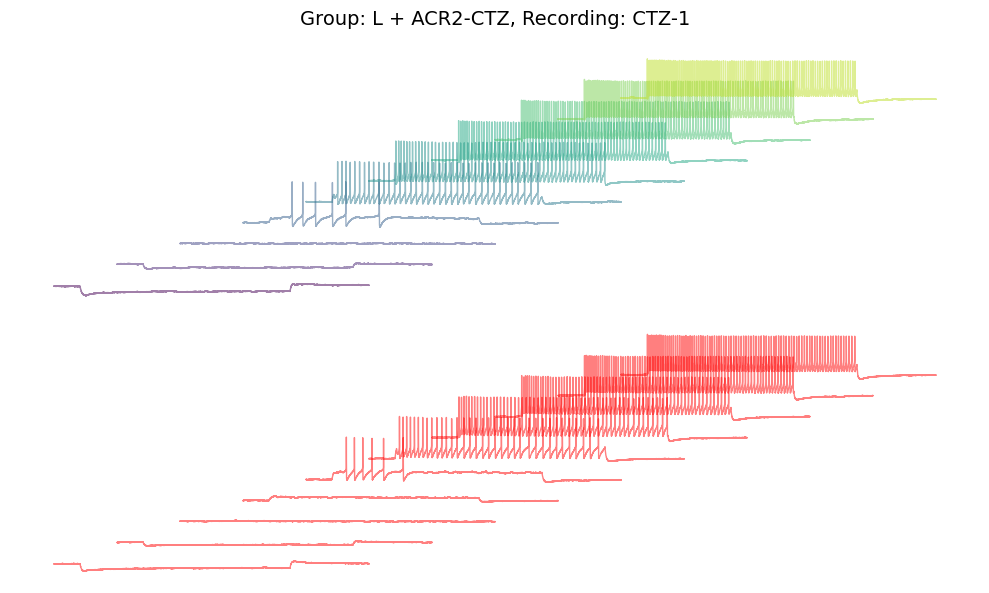

In [11]:
recording_id = processor.get_recording_ids(group)[0]  # take the first recording in the group
fig, axes = processor.plot_before_after_comparison(group, recording_id,
                                                   before_label="Before",
                                                   after_label="After",
                                                   sweep_numbers=None,  # or specify sweeps like [0, 1, 2]
                                                   startAtSec=0,
                                                   endAtSec=1.5)
plt.show()
processor.plot_scalebar(axes[1])
plt.show()

In [12]:
output_pdf_path = "/Users/ecrespo/Desktop/BLADe_patch_data_output"

processor.export_all_groups_to_pdfs(
    output_dir=output_pdf_path,
    before_label="Before",
    after_label="After",
    sweep_numbers=None,
    startAtSec=0.08,
    endAtSec=1.2,
    offsetXsec=0.3,
    offsetYunits=40,
    color_before=None,
    color_after="red",
    alpha=0.5,
    linewidth=1
)

PDF saved for group L + ACR2-CTZ at: /Users/ecrespo/Desktop/BLADe_patch_data_output/L + ACR2-CTZ_plots.pdf
PDF saved for group L + CS-CTZ at: /Users/ecrespo/Desktop/BLADe_patch_data_output/L + CS-CTZ_plots.pdf
PDF saved for group L + CS-Veh at: /Users/ecrespo/Desktop/BLADe_patch_data_output/L + CS-Veh_plots.pdf
PDF saved for group L + DUD-CTZ at: /Users/ecrespo/Desktop/BLADe_patch_data_output/L + DUD-CTZ_plots.pdf
PDF saved for group L Only at: /Users/ecrespo/Desktop/BLADe_patch_data_output/L Only_plots.pdf
PDF saved for group Plain at: /Users/ecrespo/Desktop/BLADe_patch_data_output/Plain_plots.pdf


In [13]:
output_pdf_path = "/Users/ecrespo/Desktop/BLADe_patch_data_output"

processor.export_all_groups_to_svgs(output_dir=output_pdf_path,
                                    before_label="Before",
                                    after_label="After",
                                    sweep_numbers=None,
                                    startAtSec=0.08,
                                    endAtSec=1.2,
                                    offsetXsec=0.1,
                                    offsetYunits=90,
                                    color_before="grey",
                                    color_after="blue",
                                    alpha=0.5,
                                    linewidth=0.5,
                                    dpi=300,    # For any raster elements
                                    add_suptitle=True,
                                    scaleXms=200,
                                    scaleYmV=50)

In [14]:
processor.dataframe

,Group,Recording_ID,Label,File_Path
0,L + ACR2-CTZ,CTZ-1,After,/Users/ecrespo/Desktop/BLADe_patch_data/L + AC...
1,L + ACR2-CTZ,CTZ-1,Before,/Users/ecrespo/Desktop/BLADe_patch_data/L + AC...
2,L + ACR2-CTZ,CTZ-11,After,/Users/ecrespo/Desktop/BLADe_patch_data/L + AC...
3,L + ACR2-CTZ,CTZ-11,Before,/Users/ecrespo/Desktop/BLADe_patch_data/L + AC...
4,L + ACR2-CTZ,CTZ-12,After,/Users/ecrespo/Desktop/BLADe_patch_data/L + AC...
...,...,...,...,...
114,Plain,CTZ-7,Before,/Users/ecrespo/Desktop/BLADe_patch_data/Plain/...
115,Plain,CTZ-8,After,/Users/ecrespo/Desktop/BLADe_patch_data/Plain/...
116,Plain,CTZ-8,Before,/Users/ecrespo/Desktop/BLADe_patch_data/Plain/...
117,Plain,CTZ-9,After,/Users/ecrespo/Desktop/BLADe_patch_data/Plain/...


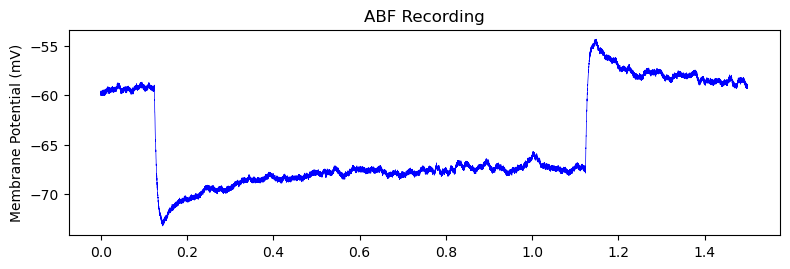

In [15]:
abf = pyabf.ABF('/Users/ecrespo/Desktop/BLADe_patch_data/L + ACR2-CTZ/L + ACR2 After CTZ-1 21224028.abf')
fig = plt.figure(figsize=(8, 5))

ax1 = fig.add_subplot(211 )
ax1.set_title("ABF Recording")
ax1.set_ylabel(abf.sweepLabelY)
ax1.plot(abf.sweepX, abf.sweepY, 'b', lw=.5)
plt.tight_layout()
plt.show()

In [16]:
output_dir = "/Users/ecrespo/Desktop/BLADe_patch_data_output"
processor.plot_sweeps_pdf(output_dir)

Saved PDF for group 'L + ACR2-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output/L + ACR2-CTZ.pdf
Saved PDF for group 'L + CS-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output/L + CS-CTZ.pdf
Saved PDF for group 'L + CS-Veh' to: /Users/ecrespo/Desktop/BLADe_patch_data_output/L + CS-Veh.pdf
Skipping incomplete pair for Link ID: CTZ-3 in group L + DUD-CTZ
Saved PDF for group 'L + DUD-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output/L + DUD-CTZ.pdf
Saved PDF for group 'L Only' to: /Users/ecrespo/Desktop/BLADe_patch_data_output/L Only.pdf
Saved PDF for group 'Plain' to: /Users/ecrespo/Desktop/BLADe_patch_data_output/Plain.pdf


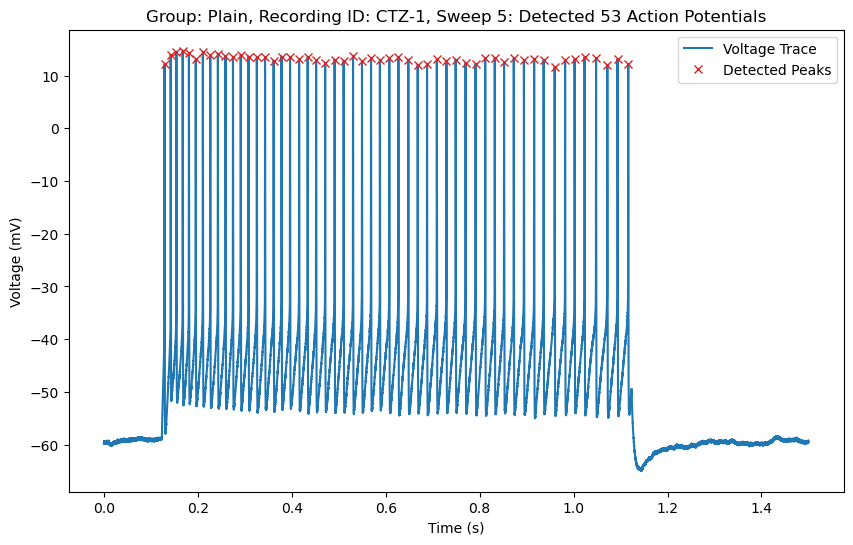

{'group': 'Plain', 'recording_id': 'CTZ-1', 'label': 'Before', 'sweep_number': 5, 'action_potential_count': 53, 'peak_indices': array([ 1291,  1422,  1544, ..., 10718, 10935, 11163])}


In [17]:
result = processor.detect_action_potentials(
    group="Plain",
    recording_id="CTZ-1",
    label="Before",
    sweep_number=5,
    height=0.1,  # Adjust based on signal properties
    prominence=0.05,
    distance=50
)

print(result)

In [18]:
output_dir = "/Users/ecrespo/Desktop/BLADe_patch_data_output_standard"
processor.create_group_pdf_with_peaks(
    output_dir=output_dir,
    height=0.1,  # Adjust based on signal properties
    prominence=0.05,
    distance=50
)

Saved wide PDF for group 'L + ACR2-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_standard/L + ACR2-CTZ_wide.pdf
Saved wide PDF for group 'L + CS-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_standard/L + CS-CTZ_wide.pdf
Saved wide PDF for group 'L + CS-Veh' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_standard/L + CS-Veh_wide.pdf
Skipping incomplete pair for Recording ID: CTZ-3 in group L + DUD-CTZ
Saved wide PDF for group 'L + DUD-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_standard/L + DUD-CTZ_wide.pdf
Saved wide PDF for group 'L Only' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_standard/L Only_wide.pdf
Saved wide PDF for group 'Plain' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_standard/Plain_wide.pdf


In [19]:
processor.create_group_pdf_with_peaks_complex(
    output_dir="/Users/ecrespo/Desktop/BLADe_patch_data_output_complex",
    height=0.1,  # Adjust based on signal properties
    prominence=0.05,
    distance=50, 
    time_range=None,
    early_phase=(0.1,0.49),
    late_phase=(0.5,1.12)
)

/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/opt/anaconda3/envs/spiketurnpike_postanalysis/lib/pyth

Saved complex PDF for group 'L + ACR2-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_complex/L + ACR2-CTZ_complex.pdf
Saved complex PDF for group 'L + CS-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_complex/L + CS-CTZ_complex.pdf
Saved complex PDF for group 'L + CS-Veh' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_complex/L + CS-Veh_complex.pdf
Skipping incomplete pair for Recording ID: CTZ-3 in group L + DUD-CTZ
Saved complex PDF for group 'L + DUD-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_complex/L + DUD-CTZ_complex.pdf
Saved complex PDF for group 'L Only' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_complex/L Only_complex.pdf
Saved complex PDF for group 'Plain' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_complex/Plain_complex.pdf


In [20]:
# groups ecdf
processor.create_group_pooled_ecdf(
    output_dir="/Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf",
    height=0.1,  
    prominence=0.05,
    distance=50,
    time_range=None,
    early_phase=(0.1, 0.49),
    late_phase=(0.5, 1.12), 
    x_min=-1.0,
    x_max=1.0,
    step_mode="mid"
)

Saved pooled ECDF PDF for group 'L + ACR2-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf/L + ACR2-CTZ_pooled_ecdf.pdf
Saved pooled ECDF PDF for group 'L + CS-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf/L + CS-CTZ_pooled_ecdf.pdf
Saved pooled ECDF PDF for group 'L + CS-Veh' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf/L + CS-Veh_pooled_ecdf.pdf
Skipping incomplete pair for Recording ID: CTZ-3 in group L + DUD-CTZ
Saved pooled ECDF PDF for group 'L + DUD-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf/L + DUD-CTZ_pooled_ecdf.pdf
Saved pooled ECDF PDF for group 'L Only' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf/L Only_pooled_ecdf.pdf
Saved pooled ECDF PDF for group 'Plain' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf/Plain_pooled_ecdf.pdf


In [21]:
processor.create_group_pooled_ecdf_svg(
    output_dir="/Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs",
    height=0.1,  
    prominence=0.05,
    distance=50,
    time_range=None,
    early_phase=(0.1, 0.49),
    late_phase=(0.5, 1.12), 
    x_min=-1.0,
    x_max=1.0,
    step_mode="mid", 
    fig_width=5,
    fig_height=3,
    remove_spines=True,
    transparent=True
)

Saved pooled ECDF SVG for group 'L + ACR2-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs/L + ACR2-CTZ_pooled_ecdf.svg
Saved pooled ECDF SVG for group 'L + CS-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs/L + CS-CTZ_pooled_ecdf.svg
Saved pooled ECDF SVG for group 'L + CS-Veh' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs/L + CS-Veh_pooled_ecdf.svg
Skipping incomplete pair for Recording ID: CTZ-3 in group L + DUD-CTZ
Saved pooled ECDF SVG for group 'L + DUD-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs/L + DUD-CTZ_pooled_ecdf.svg
Saved pooled ECDF SVG for group 'L Only' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs/L Only_pooled_ecdf.svg
Saved pooled ECDF SVG for group 'Plain' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs/Plain_pooled_ecdf.svg


In [22]:
processor.create_group_pooled_mean_and_individual_traces_ecdf(
    output_dir="/Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs_individual",
    height=0.1,
    prominence=0.05,
    distance=50,
    time_range=None,
    early_phase=(0.1, 0.49),
    late_phase=(0.5, 1.12),
    x_min=-1.0,
    x_max=1.0,
    step_mode="mid",
    fig_width=5,
    fig_height=3,
    remove_spines=True,
    transparent=True,
    individual_line_alpha=0.3,
    individual_line_style=":",
    individual_line_width=0.5
)


Saved pooled ECDF with individual traces for group 'L + ACR2-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs_individual/L + ACR2-CTZ_pooled_ecdf_individual.svg
Saved pooled ECDF with individual traces for group 'L + CS-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs_individual/L + CS-CTZ_pooled_ecdf_individual.svg
Saved pooled ECDF with individual traces for group 'L + CS-Veh' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs_individual/L + CS-Veh_pooled_ecdf_individual.svg
Skipping incomplete pair for Recording ID: CTZ-3 in group L + DUD-CTZ
Saved pooled ECDF with individual traces for group 'L + DUD-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs_individual/L + DUD-CTZ_pooled_ecdf_individual.svg
Saved pooled ECDF with individual traces for group 'L Only' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs_individual/L Only_pooled_ecdf_individual.svg
Saved pooled ECDF with individual traces for group 'Plain' to:

In [23]:
processor.create_group_pooled_mean_and_individual_sigmoid_ecdf(
    output_dir="/Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs_sigmoid",
    height=0.1,
    prominence=0.05,
    distance=50,
    time_range=None,
    early_phase=(0.1, 0.49),
    late_phase=(0.5, 1.12),
    x_min=-1.0,
    x_max=1.0,
    fig_width=5,
    fig_height=3,
    remove_spines=True,
    transparent=True,
    individual_line_alpha=0.3,
    individual_line_style=":",
    individual_line_width=0.5,
    smoothing_factor=1.0
)

Saved pooled sigmoid ECDF with individual traces for group 'L + ACR2-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs_sigmoid/L + ACR2-CTZ_pooled_sigmoid_ecdf_individual.svg


/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1239918976.py:2699: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(logistic, x_data, y_data, p0=[x0_guess, k_guess])


Saved pooled sigmoid ECDF with individual traces for group 'L + CS-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs_sigmoid/L + CS-CTZ_pooled_sigmoid_ecdf_individual.svg
Saved pooled sigmoid ECDF with individual traces for group 'L + CS-Veh' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs_sigmoid/L + CS-Veh_pooled_sigmoid_ecdf_individual.svg
Skipping incomplete pair for Recording ID: CTZ-3 in group L + DUD-CTZ
Saved pooled sigmoid ECDF with individual traces for group 'L + DUD-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs_sigmoid/L + DUD-CTZ_pooled_sigmoid_ecdf_individual.svg
Saved pooled sigmoid ECDF with individual traces for group 'L Only' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs_sigmoid/L Only_pooled_sigmoid_ecdf_individual.svg
Saved pooled sigmoid ECDF with individual traces for group 'Plain' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs_sigmoid/Plain_pooled_sigmoid_ecdf_individual.svg


In [24]:
cell_data_df, summary_df = processor.compare_group_distributions()

In [25]:
print(cell_data_df)


             Group Condition  FractionDifference
0     L + ACR2-CTZ    Before           -0.352445
1     L + ACR2-CTZ    Before           -0.350154
2     L + ACR2-CTZ    Before           -0.351382
3     L + ACR2-CTZ    Before           -0.361946
4     L + ACR2-CTZ    Before           -0.357046
...            ...       ...                 ...
1175         Plain     After           -0.359400
1176         Plain     After           -0.343123
1177         Plain     After           -0.362190
1178         Plain     After           -0.339753
1179         Plain     After           -0.325525

[1180 rows x 3 columns]


In [26]:
print(summary_df)

          Group  N_Before_Values  N_After_Values  KS_Statistic  KS_pValue
0  L + ACR2-CTZ              110             110      0.227273   0.006656
1    L + CS-CTZ              110             110      0.100000   0.643622
2    L + CS-Veh               90              90      0.100000   0.762125
3   L + DUD-CTZ               60              60      0.133333   0.664751
4        L Only              110             110      0.100000   0.643622
5         Plain              110             110      0.109091   0.531512


In [27]:
processor.create_group_pooled_mean_and_individual_smoothed_ecdf(
    output_dir="/Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs_smoothed",
    height=0.1,
    prominence=0.05,
    distance=50,
    time_range=None,
    early_phase=(0.1, 0.49),
    late_phase=(0.5, 1.12),
    x_min=-1.0,
    x_max=1.0,
    fig_width=5,
    fig_height=3,
    remove_spines=True,
    transparent=True,
    individual_line_alpha=0.3,
    individual_line_style=":",
    individual_line_width=0.5,
    main_line_width=1.5,
    smoothing_window=-.01
)

Saved pooled smoothed ECDF with individual traces for group 'L + ACR2-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs_smoothed/L + ACR2-CTZ_pooled_smoothed_ecdf_individual.svg
Saved pooled smoothed ECDF with individual traces for group 'L + CS-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs_smoothed/L + CS-CTZ_pooled_smoothed_ecdf_individual.svg
Saved pooled smoothed ECDF with individual traces for group 'L + CS-Veh' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs_smoothed/L + CS-Veh_pooled_smoothed_ecdf_individual.svg
Skipping incomplete pair for Recording ID: CTZ-3 in group L + DUD-CTZ
Saved pooled smoothed ECDF with individual traces for group 'L + DUD-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs_smoothed/L + DUD-CTZ_pooled_smoothed_ecdf_individual.svg
Saved pooled smoothed ECDF with individual traces for group 'L Only' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_ecdf_svgs_smoothed/L Only_pooled_smoothed_ec

In [28]:
output_dir = "/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized"
processor.create_group_pdf_with_peaks(
    output_dir=output_dir,
    height=0.08,  # Adjust based on signal properties
    prominence=0.1,
    distance=30, 
    width=0.01
)

Saved wide PDF for group 'L + ACR2-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/L + ACR2-CTZ_wide.pdf
Saved wide PDF for group 'L + CS-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/L + CS-CTZ_wide.pdf
Saved wide PDF for group 'L + CS-Veh' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/L + CS-Veh_wide.pdf
Skipping incomplete pair for Recording ID: CTZ-3 in group L + DUD-CTZ
Saved wide PDF for group 'L + DUD-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/L + DUD-CTZ_wide.pdf
Saved wide PDF for group 'L Only' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/L Only_wide.pdf
Saved wide PDF for group 'Plain' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/Plain_wide.pdf


In [29]:
processor.process_peaks(
    height=0.08,  # Adjust based on signal properties
    prominence=0.1,
    distance=30, 
    width=0.01,
    save_csv_path='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data.csv'
)

Processed peaks for 1190 sweeps.
Saved peak data to /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data.csv.


In [30]:
processor.import_csv_and_plot_mean_peaks(
    csv_path='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_modified.csv',
    output_pdf_path='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_modified_plot.pdf'
)

Saved mean AP count plots to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_modified_plot.pdf


In [31]:
processor.import_csv_and_plot_mean_peaks_lineplot(csv_path='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_modified.csv',
    output_pdf_path='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_modified_lineplot.pdf')

Saved line plots for mean AP counts to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_modified_lineplot.pdf


In [32]:
processor.import_csv_and_plot_mean_peaks_with_error_bars(csv_path='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_modified.csv',
    output_pdf_path='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_modified_lineplotwitherrorbars.pdf')

Saved error bar plots for mean AP counts to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_modified_lineplotwitherrorbars.pdf


In [33]:
processor.import_csv_and_plot_mean_peaks_with_error_bars_svg(
    csv_path='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_modified.csv',
    output_dir='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/svg_lineplots',
    fig_width=5,
    fig_height=3, 
    ymin=-10, 
    ymax=70,
    )

Saved error bar plots as transparent SVG files in: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/svg_lineplots


In [34]:
processor.process_peaks_in_window(height=0.8,
    prominence=0.2,
    distance=20,
    start_time=0.1,
    end_time=1.2,
    save_csv_path='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_specific_window.csv')

Processed peaks for 1190 sweeps.
Saved peak data to /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_specific_window.csv.


In [35]:
processor.import_csv_and_plot_mean_peaks_with_error_bars(csv_path='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_specific_window.csv',
    output_pdf_path='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_modified_lineplotwitherrorbars_specific_window.pdf')

Saved error bar plots for mean AP counts to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_modified_lineplotwitherrorbars_specific_window.pdf


In [36]:
processor.peak_window_dataframe

,Group,Recording_ID,Label,Sweep_Number,Start_Time,End_Time,AP_Count
0,L + ACR2-CTZ,CTZ-1,After,0,0.1,1.2,0
1,L + ACR2-CTZ,CTZ-1,After,1,0.1,1.2,0
2,L + ACR2-CTZ,CTZ-1,After,2,0.1,1.2,0
3,L + ACR2-CTZ,CTZ-1,After,3,0.1,1.2,0
4,L + ACR2-CTZ,CTZ-1,After,4,0.1,1.2,6
...,...,...,...,...,...,...,...
1185,Plain,CTZ-9,Before,5,0.1,1.2,18
1186,Plain,CTZ-9,Before,6,0.1,1.2,15
1187,Plain,CTZ-9,Before,7,0.1,1.2,4
1188,Plain,CTZ-9,Before,8,0.1,1.2,1


In [50]:
processor.process_peaks_by_phase(
    height=0.8,
    prominence=0.2,
    distance=20,
    early_start=0.1,
    early_end=0.2,
    late_start=0.21,
    late_end=0.41,
    save_csv_path=None
)

Processed early and late peaks for 1190 sweeps.


In [51]:
processor.phase_peak_dataframe

,Group,Recording_ID,Label,Sweep_Number,Early_AP_Count,Late_AP_Count,Early_Indices,Late_Indices,Early_Start_Time,Early_End_Time,Late_Start_Time,Late_End_Time
0,L + ACR2-CTZ,CTZ-1,After,0,0,0,[],[],0.1,0.2,0.21,0.41
1,L + ACR2-CTZ,CTZ-1,After,1,0,0,[],[],0.1,0.2,0.21,0.41
2,L + ACR2-CTZ,CTZ-1,After,2,0,0,[],[],0.1,0.2,0.21,0.41
3,L + ACR2-CTZ,CTZ-1,After,3,0,0,[],[],0.1,0.2,0.21,0.41
4,L + ACR2-CTZ,CTZ-1,After,4,1,4,[1920],"[2304, 2701, 3142, 3692]",0.1,0.2,0.21,0.41
...,...,...,...,...,...,...,...,...,...,...,...,...
1185,Plain,CTZ-9,Before,5,1,5,[1283],"[2371, 2528, 3005, 3165, 3332]",0.1,0.2,0.21,0.41
1186,Plain,CTZ-9,Before,6,4,5,"[1659, 1762, 1875, 1990]","[2107, 2225, 2345, 3643, 3907]",0.1,0.2,0.21,0.41
1187,Plain,CTZ-9,Before,7,4,0,"[1410, 1574, 1859, 1962]",[],0.1,0.2,0.21,0.41
1188,Plain,CTZ-9,Before,8,1,0,[1317],[],0.1,0.2,0.21,0.41


In [52]:
# Assuming `processor` is your class instance
processor.create_group_pdf_with_deltas_from_dataframe(output_dir='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/')

/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:1158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_data["Delta_AP"] = before_data["Late_AP_Count"] - before_data["Early_AP_Count"]
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:1159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_data["Delta_AP"] = after_data["Late_AP_Count"] - after_data["Early_AP_Count"]
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:


Group: L + ACR2-CTZ, Recording ID: CTZ-1
Before ΔAP:
    Sweep_Number  Early_AP_Count  Late_AP_Count  Delta_AP
10             0               0              0         0
11             1               0              0         0
12             2               0              0         0
13             3               0              3         3
14             4               3              9         6
15             5               6             12         6
16             6               7             16         9
17             7               9             18         9
18             8              10             20        10
19             9              11             22        11
After ΔAP:
   Sweep_Number  Early_AP_Count  Late_AP_Count  Delta_AP
0             0               0              0         0
1             1               0              0         0
2             2               0              0         0
3             3               0              0         0
4           

/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:1158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_data["Delta_AP"] = before_data["Late_AP_Count"] - before_data["Early_AP_Count"]
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:1159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_data["Delta_AP"] = after_data["Late_AP_Count"] - after_data["Early_AP_Count"]
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:


Group: L + ACR2-CTZ, Recording ID: CTZ-5
Before ΔAP:
     Sweep_Number  Early_AP_Count  Late_AP_Count  Delta_AP
130             0               0              0         0
131             1               0              0         0
132             2               0              0         0
133             3               2              0        -2
134             4               5              8         3
135             5               6             11         5
136             6               7             12         5
137             7               8             15         7
138             8               9             17         8
139             9              10             18         8
After ΔAP:
     Sweep_Number  Early_AP_Count  Late_AP_Count  Delta_AP
120             0               0              0         0
121             1               0              0         0
122             2               0              0         0
123             3               0              0  

/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:1158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_data["Delta_AP"] = before_data["Late_AP_Count"] - before_data["Early_AP_Count"]
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:1159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_data["Delta_AP"] = after_data["Late_AP_Count"] - after_data["Early_AP_Count"]
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:


Group: L + CS-CTZ, Recording ID: CTZ-13
Before ΔAP:
     Sweep_Number  Early_AP_Count  Late_AP_Count  Delta_AP
290             0               0              0         0
291             1               0              0         0
292             2               0              0         0
293             3               0              0         0
294             4               0              0         0
295             5               0              0         0
296             6               0              0         0
297             7               2              0        -2
298             8               3              0        -3
299             9               5              0        -5
After ΔAP:
     Sweep_Number  Early_AP_Count  Late_AP_Count  Delta_AP
280             0               0              0         0
281             1               0              0         0
282             2               0              0         0
283             3               0              0   

/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:1158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_data["Delta_AP"] = before_data["Late_AP_Count"] - before_data["Early_AP_Count"]
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:1159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_data["Delta_AP"] = after_data["Late_AP_Count"] - after_data["Early_AP_Count"]
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:


Group: L + CS-Veh, Recording ID: Veh-6
Before ΔAP:
     Sweep_Number  Early_AP_Count  Late_AP_Count  Delta_AP
570             0               0              0         0
571             1               0              0         0
572             2               0              0         0
573             3               0              0         0
574             4               1              0        -1
575             5               2              0        -2
576             6               2              2         0
577             7               3              2        -1
578             8               3              5         2
579             9               4              7         3
After ΔAP:
     Sweep_Number  Early_AP_Count  Late_AP_Count  Delta_AP
560             0               0              0         0
561             1               0              0         0
562             2               0              0         0
563             3               0              0    

/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:1158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_data["Delta_AP"] = before_data["Late_AP_Count"] - before_data["Early_AP_Count"]
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:1159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_data["Delta_AP"] = after_data["Late_AP_Count"] - after_data["Early_AP_Count"]
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:


Group: L + DUD-CTZ, Recording ID: CTZ-6
Before ΔAP:
     Sweep_Number  Early_AP_Count  Late_AP_Count  Delta_AP
720             0               0              0         0
721             1               0              0         0
722             2               0              0         0
723             3               0              0         0
724             4               0              0         0
725             5               0              0         0
726             6               1              0        -1
727             7               3              0        -3
728             8               4              5         1
729             9               5              9         4
After ΔAP:
     Sweep_Number  Early_AP_Count  Late_AP_Count  Delta_AP
710             0               0              0         0
711             1               0              0         0
712             2               0              0         0
713             3               0              0   

/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:1158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_data["Delta_AP"] = before_data["Late_AP_Count"] - before_data["Early_AP_Count"]
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:1159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_data["Delta_AP"] = after_data["Late_AP_Count"] - after_data["Early_AP_Count"]
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:


Group: L Only, Recording ID: CTZ-3
Before ΔAP:
     Sweep_Number  Early_AP_Count  Late_AP_Count  Delta_AP
880             0               0              0         0
881             1               0              0         0
882             2               0              0         0
883             3               0              0         0
884             4               0              0         0
885             5               0              0         0
886             6               0              0         0
887             7               0              2         2
888             8               2              6         4
889             9               4              5         1
After ΔAP:
     Sweep_Number  Early_AP_Count  Late_AP_Count  Delta_AP
870             0               0              0         0
871             1               0              0         0
872             2               0              0         0
873             3               0              0        

/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:1158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_data["Delta_AP"] = before_data["Late_AP_Count"] - before_data["Early_AP_Count"]
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:1159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_data["Delta_AP"] = after_data["Late_AP_Count"] - after_data["Early_AP_Count"]
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:


Group: Plain, Recording ID: CTZ-12
Before ΔAP:
      Sweep_Number  Early_AP_Count  Late_AP_Count  Delta_AP
1040             0               0              0         0
1041             1               0              0         0
1042             2               0              0         0
1043             3               0              0         0
1044             4               0              0         0
1045             5               0              0         0
1046             6               3              1        -2
1047             7               5              9         4
1048             8               7             12         5
1049             9               7             14         7
After ΔAP:
      Sweep_Number  Early_AP_Count  Late_AP_Count  Delta_AP
1030             0               0              0         0
1031             1               0              0         0
1032             2               0              0         0
1033             3               0       

/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:1158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_data["Delta_AP"] = before_data["Late_AP_Count"] - before_data["Early_AP_Count"]
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:1159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_data["Delta_AP"] = after_data["Late_AP_Count"] - after_data["Early_AP_Count"]
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_25995/1200596758.py:

In [53]:
processor.create_group_pdf_with_early_vs_late_counts(output_dir='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/')

Saved Early vs. Late Phase Spike Counts PDF for group 'L + ACR2-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/L + ACR2-CTZ_early_vs_late_counts.pdf
Saved Early vs. Late Phase Spike Counts PDF for group 'L + CS-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/L + CS-CTZ_early_vs_late_counts.pdf
Saved Early vs. Late Phase Spike Counts PDF for group 'L + CS-Veh' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/L + CS-Veh_early_vs_late_counts.pdf
Skipping recording CTZ-3 in group L + DUD-CTZ: Missing 'Before' or 'After' data.
Saved Early vs. Late Phase Spike Counts PDF for group 'L + DUD-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/L + DUD-CTZ_early_vs_late_counts.pdf
Saved Early vs. Late Phase Spike Counts PDF for group 'L Only' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/L Only_early_vs_late_counts.pdf
Saved Early vs. Late Phase Spike Counts PDF for group 'Plain' to: /Users/ecrespo/Desktop/BLADe_patch_

In [54]:
processor.create_group_pdf_with_early_to_late_ratios(output_dir='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/')

Saved Early-to-Late Ratio PDF for group 'L + ACR2-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/L + ACR2-CTZ_early_to_late_ratios.pdf
Saved Early-to-Late Ratio PDF for group 'L + CS-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/L + CS-CTZ_early_to_late_ratios.pdf
Saved Early-to-Late Ratio PDF for group 'L + CS-Veh' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/L + CS-Veh_early_to_late_ratios.pdf
Saved Early-to-Late Ratio PDF for group 'L + DUD-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/L + DUD-CTZ_early_to_late_ratios.pdf
Saved Early-to-Late Ratio PDF for group 'L Only' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/L Only_early_to_late_ratios.pdf
Saved Early-to-Late Ratio PDF for group 'Plain' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/Plain_early_to_late_ratios.pdf


In [55]:
processor.create_group_pdf_with_mean_and_sem(output_dir='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/')

Saved group mean and SEM ΔAP PDF to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/group_mean_and_sem_delta_ap.pdf


In [56]:
processor.create_group_pdf_with_mean_and_sem_and_store_data(output_dir='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/')

Saved group mean and SEM ΔAP PDF to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/group_mean_and_sem_delta_ap.pdf


In [58]:
stats_results = processor.run_two_way_anova_with_correction()


Group: L + ACR2-CTZ
                Anova
          F Value Num DF Den DF Pr > F
--------------------------------------
Condition  6.8044 1.0000 9.0000 0.0283

Corrected P-Values: [0.0283]

Group: L + CS-CTZ
                Anova
          F Value Num DF Den DF Pr > F
--------------------------------------
Condition  7.7960 1.0000 9.0000 0.0210

Corrected P-Values: [0.021]

Group: L + CS-Veh
                Anova
          F Value Num DF Den DF Pr > F
--------------------------------------
Condition  3.2727 1.0000 9.0000 0.1039

Corrected P-Values: [0.1039]

Group: L + DUD-CTZ
                Anova
          F Value Num DF Den DF Pr > F
--------------------------------------
Condition  0.6763 1.0000 9.0000 0.4321

Corrected P-Values: [0.4321]

Group: L Only
                Anova
          F Value Num DF Den DF Pr > F
--------------------------------------
Condition  0.1736 1.0000 9.0000 0.6867

Corrected P-Values: [0.6867]

Group: Plain
                Anova
          F Value Num DF D

In [59]:
stats_results

({'L + ACR2-CTZ': {'anova_summary': <class 'statsmodels.iolib.summary2.Summary'>
   """
                   Anova
             F Value Num DF Den DF Pr > F
   --------------------------------------
   Condition  6.8044 1.0000 9.0000 0.0283
   
   """,
   'corrected_p_values': array([0.0283])},
  'L + CS-CTZ': {'anova_summary': <class 'statsmodels.iolib.summary2.Summary'>
   """
                   Anova
             F Value Num DF Den DF Pr > F
   --------------------------------------
   Condition  7.7960 1.0000 9.0000 0.0210
   
   """,
   'corrected_p_values': array([0.021])},
  'L + CS-Veh': {'anova_summary': <class 'statsmodels.iolib.summary2.Summary'>
   """
                   Anova
             F Value Num DF Den DF Pr > F
   --------------------------------------
   Condition  3.2727 1.0000 9.0000 0.1039
   
   """,
   'corrected_p_values': array([0.1039])},
  'L + DUD-CTZ': {'anova_summary': <class 'statsmodels.iolib.summary2.Summary'>
   """
                   Anova
           

In [45]:
# Helper functions
def load_trace_data(file_path, time_window):
    """
    Load and slice trace data for a given file and time window.

    Args:
        file_path (str): Path to the trace data file (e.g., ABF file).
        time_window (tuple): (start, end) time range to extract.

    Returns:
        tuple: (time, voltage), arrays of time and voltage data within the window.
    """
    abf = pyabf.ABF(file_path)
    abf.setSweep(0)  # Use the first sweep for simplicity
    time = abf.sweepX
    voltage = abf.sweepY

    # Apply time window
    mask = (time >= time_window[0]) & (time <= time_window[1])
    return time[mask], voltage[mask]


def plot_traces(ax_before, ax_after, time_before, voltage_before, time_after, voltage_after):
    """
    Plot Before and After traces on separate axes.

    Args:
        ax_before (matplotlib axis): Axis to plot Before trace.
        ax_after (matplotlib axis): Axis to plot After trace.
        time_before, time_after: Time arrays for Before and After traces.
        voltage_before, voltage_after: Voltage arrays for Before and After traces.
    """
    # Plot Before traces
    ax_before.plot(time_before, voltage_before, color="gray")
    ax_before.set_title("Before", fontsize=8)
    ax_before.set_xlabel("Time (s)", fontsize=6)
    ax_before.set_ylabel("Voltage (mV)", fontsize=6)

    # Plot After traces
    ax_after.plot(time_after, voltage_after, color="blue")
    ax_after.set_title("After", fontsize=8)
    ax_after.set_xlabel("Time (s)", fontsize=6)


def plot_combined_io_curve(ax, before_data, after_data):
    """
    Overlay Before and After Input-Output curves on a single axis.

    Args:
        ax (matplotlib axis): Axis to plot on.
        before_data (DataFrame): Filtered data for the Before condition.
        after_data (DataFrame): Filtered data for the After condition.
    """
    # Compute mean and SEM for Before
    mean_before = before_data.groupby("Sweep_Number")["AP_Count"].mean()
    sem_before = before_data.groupby("Sweep_Number")["AP_Count"].sem()

    # Compute mean and SEM for After
    mean_after = after_data.groupby("Sweep_Number")["AP_Count"].mean()
    sem_after = after_data.groupby("Sweep_Number")["AP_Count"].sem()

    # Sweep numbers
    sweep_numbers = mean_before.index

    # Plot Before data
    ax.errorbar(
        sweep_numbers,
        mean_before,
        yerr=sem_before,
        fmt="o",
        color="gray",
        label="Before",
        capsize=3,
        markersize=4,
    )

    # Plot After data
    ax.errorbar(
        sweep_numbers,
        mean_after,
        yerr=sem_after,
        fmt="o",
        color="blue",
        label="After",
        capsize=3,
        markersize=4,
    )

    # Add labels, legend, and title
    ax.set_xlabel("Sweep Number", fontsize=6)
    ax.set_ylabel("Mean AP Count (± SEM)", fontsize=6)
    ax.legend(fontsize=6)
    ax.grid(True, linestyle="--", linewidth=0.5)

def create_final_figure_with_specified_recordings(
    recording_ids,  # List of Recording_IDs to plot
    processor,
    time_window,
    csv_path,
    output_pdf_path,
    io_y_range=None  # User-defined y-axis range for Input-Output curves
):
    """
    Create a single-page figure plotting selected sweeps for specified recordings and group-level mean/SEM Input-Output curves.

    Args:
        recording_ids (list): List of Recording_IDs specifying which recordings to plot.
        processor: An object containing the DataFrame with traces information.
        time_window (tuple): Time window for trace extraction (start, end).
        csv_path (str): Path to CSV file containing peak data for Input-Output curves.
        output_pdf_path (str): Path to save the final PDF.
        io_y_range (tuple): User-defined y-axis range for Input-Output curves (min, max). If None, range is auto-detected.
    """
    # Load the Input-Output (I-O) data from the CSV
    try:
        peak_data = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"File not found: {csv_path}")
        return

    # Validate the DataFrame
    if processor.dataframe is None or processor.dataframe.empty:
        print("No data available in processor.dataframe.")
        return

    # Set up the figure
    plt.rcParams.update({"font.family": "Arial", "font.size": 8})
    fig = plt.figure(figsize=(6.5, 8))
    gs = gridspec.GridSpec(10, 4, figure=fig)  # 4 columns: Before, After, I-O Before/After
    plt.subplots_adjust(wspace=0.4, hspace=0.6)

    # Determine y-axis range for Input-Output curves
    if io_y_range is None:
        io_y_limits = [float("inf"), -float("inf")]
        for group in processor.unique_groups:
            group_before_data = peak_data[(peak_data["Group"] == group) & (peak_data["Label"] == "Before")]
            group_after_data = peak_data[(peak_data["Group"] == group) & (peak_data["Label"] == "After")]
            io_y_limits[0] = min(io_y_limits[0], group_before_data["AP_Count"].min(), group_after_data["AP_Count"].min())
            io_y_limits[1] = max(io_y_limits[1], group_before_data["AP_Count"].max(), group_after_data["AP_Count"].max())
    else:
        io_y_limits = io_y_range

    # Plot all specified recordings
    for i, recording_id in enumerate(recording_ids[:5]):  # Limit to 5 recordings (10 rows total)
        # Find the group and file paths for the given Recording_ID
        rep_data = processor.dataframe[processor.dataframe["Recording_ID"] == recording_id]
        if rep_data.empty:
            print(f"No data found for Recording_ID: {recording_id}")
            continue

        group = rep_data["Group"].iloc[0]  # Get the corresponding group
        before_file = rep_data[rep_data["Label"] == "Before"]["File_Path"].iloc[0]
        after_file = rep_data[rep_data["Label"] == "After"]["File_Path"].iloc[0]

        # Load Before and After traces for every other sweep
        before_abf = pyabf.ABF(before_file)
        after_abf = pyabf.ABF(after_file)

        # Plot selected Before sweeps
        ax_before = fig.add_subplot(gs[i * 2:i * 2 + 2, 0])  # Column 1
        for sweep_number in before_abf.sweepList[::2]:  # Every other sweep
            before_abf.setSweep(sweep_number)
            time_before = before_abf.sweepX
            voltage_before = before_abf.sweepY
            mask = (time_before >= time_window[0]) & (time_before <= time_window[1])
            ax_before.plot(time_before[mask], voltage_before[mask], color="gray", alpha=0.7, linewidth=0.8)
        ax_before.set_title(f"{group} - Before", fontsize=8)
        ax_before.set_xlabel("Time (s)", fontsize=6)
        ax_before.set_ylabel("Voltage (mV)", fontsize=6)

        # Plot selected After sweeps
        ax_after = fig.add_subplot(gs[i * 2:i * 2 + 2, 1])  # Column 2
        for sweep_number in after_abf.sweepList[::2]:  # Every other sweep
            after_abf.setSweep(sweep_number)
            time_after = after_abf.sweepX
            voltage_after = after_abf.sweepY
            mask = (time_after >= time_window[0]) & (time_after <= time_window[1])
            ax_after.plot(time_after[mask], voltage_after[mask], color="blue", alpha=0.7, linewidth=0.8)
        ax_after.set_title(f"{group} - After", fontsize=8)
        ax_after.set_xlabel("Time (s)", fontsize=6)

        # Plot mean and SEM Input-Output curves for the entire group
        ax_io = fig.add_subplot(gs[i * 2:i * 2 + 2, 2:4])  # Columns 3 and 4 (spanning 2 columns)
        group_before_data = peak_data[(peak_data["Group"] == group) & (peak_data["Label"] == "Before")]
        group_after_data = peak_data[(peak_data["Group"] == group) & (peak_data["Label"] == "After")]
        plot_combined_io_curve(ax_io, group_before_data, group_after_data)
        ax_io.set_ylim(io_y_limits)
        ax_io.set_title(f"I-O Curve: {group}", fontsize=8)

    # Save the final figure to the PDF
    os.makedirs(os.path.dirname(output_pdf_path), exist_ok=True)
    with PdfPages(output_pdf_path) as pdf:
        pdf.savefig(fig)
    plt.close(fig)

    print(f"Final figure saved to: {output_pdf_path}")
    

recording_ids = [
    "CTZ-5",  # Recording_ID from Group 'L + ACR2-CTZ'
    "CTZ-15",  # Recording_ID from Group 'L + CS-CTZ'
    "Veh-6",  # Recording_ID from Group 'L + CS-Veh'
    "CTZ-9",  # Recording_ID from Group 'L + DUD-CTZ'
    "CTZ-10",  # Recording_ID from Group 'Plain'
]

time_window = (0, 1.2)  # Specify your desired time window (start, end in seconds)
csv_path = "/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_modified.csv"
output_pdf_path = "/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/final_attempt.pdf"


create_final_figure_with_specified_recordings(recording_ids, processor, time_window, csv_path, output_pdf_path, io_y_range=(0, 50))

Final figure saved to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/final_attempt.pdf
